<font size="85">New Brunswick 27° Gable Roof Building: Wind Tunnel Test</font> <br>
***
Feb 25, 2023

# <a id='toc1_'></a>[Project description](#toc0_)

The study building is a $27^\circ$ gable roof building with ridge height 9.8 m, width 14 m, and length 41 m. It is situated in a suburban surrounding all around except the North end. The North is exposed to an open terrain from the airport except for a couple of houses immediately next to it. 

| Parameter | Value |
| --- | --- |
| Geometric scale | 1:100 |
| Velocity scale | TBD |
| Sampling period | 180s |
| Sampling frequency | 500Hz |
| Reference wind tunnel speed | 60fps |
| Number of exposures to be tested | Two exposures |
| Profile measurement | Not required |
| Tunnel setup | The tunnel configurations for the two exposures are given in Table 1 |
| Pressure taps | 440 taps (see Figure 3 for the layout) |
| Number of scanners required | 30 |
| Test angles, $\theta$ | 0° to 350° at 10°, 45°, 135°, 225°, and 315°. (40 directions) |
| Number of runs | 8 (2 field conditions of Case 1, 6 for the other cases) |
| Other instrumentation | None |
| Dummy models | The dummy models will be built from the dense foam typically used by BLWTL to model surrounding buildings. |
| Turntable setup | Several neighboring buildings and trees close to the study building will be crudely modeled for Case 1. |


**Case matrix**
| Case | Name | Surround | Exp-2 | Exp-4 |
| --- | --- | --- | --- | --- |
| 1 | fld | X | X | X |
| 2 | iso |  | X |  |
| 3 | xd |  | X |  |
| 4 | xdd |  | X |  |
| 5 | dxd |  | X |  |
| 6 | xddd |  | X |  |
| 7 | dxdd |  | X |  |



**Table of contents**<a id='toc0_'></a>    
- [Project description](#toc1_)    
- [Basic definitions](#toc2_)    
    - [Files and directories](#toc2_1_1_)    
    - [General parameters](#toc2_1_2_)    
    - [Scaling](#toc2_1_3_)    
- [Building Geometry](#toc3_)    
    - [Basic geometry](#toc3_1_1_)    
    - [Basics of faces](#toc3_1_2_)    
    - [Zone dictionary](#toc3_1_3_)    
    - [Face objects](#toc3_1_4_)    
    - [Building objects](#toc3_1_5_)    
    - [Geometry plots](#toc3_1_6_)    
- [Load and process data](#toc4_)    
  - [Field data](#toc4_1_)    
  - [Wind tunnel](#toc4_2_)    
    - [Wind field](#toc4_2_1_)    
    - [Pressure](#toc4_2_2_)    
- [Plot results](#toc5_)    
    - [Field data only](#toc5_1_1_)    
      - [Field data wind rose](#toc5_1_1_1_)    
    - [Wind field](#toc5_1_2_)    
      - [All profiles](#toc5_1_2_1_)    
      - [Selected profiles and spectra](#toc5_1_2_2_)    
      - [WT vs. Field vs. ESDU](#toc5_1_2_3_)    
    - [Pressure](#toc5_1_3_)    
      - [$C_p$ contours](#toc5_1_3_1_)    
      - [$C_p$ vs. AoA per tap](#toc5_1_3_2_)    
      - [C&C pressure coefficients from codes](#toc5_1_3_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Basic definitions](#toc0_)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import wind
import windWT as wt
import windCAD
import windCodes

import winsound

# plt.rcParams['text.usetex'] = False 
# plt.rcParams['font.family'] = 'serif'

plt.rcParams['font.family'] = 'sans-serif'

### <a id='toc2_1_1_'></a>[Files and directories](#toc0_)

In [141]:
# Directories
rawHFPIdir = r"F:/nrcNB_windTunnelData/rawHFPI/"
workDir = r"D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/"
rawVelDir = workDir + r"Data/windTunnel/profiles/"
outputDir = workDir + r"Data/windTunnel/gable27deg/"
figDir = outputDir + r"__plots/"
exportDir = outputDir + r"__export/"

# Files
tapFile = workDir + r"Drawings/nrcNBwtTapDefinition.csv"

if not os.path.exists(outputDir):
    os.makedirs(outputDir)
if not os.path.exists(figDir):
    os.makedirs(figDir)
if not os.path.exists(exportDir):
    os.makedirs(exportDir)

### <a id='toc2_1_2_'></a>[General parameters](#toc0_)

In [110]:
saveFigs = True
exposure = 'E2'
cases = 'c2'

caseName_iso_OP = 'nrcNBc2E2'
casedir_iso_OP = rawHFPIdir+caseName_iso_OP+r"/"

caseName_iso_SU = 'nrcNBc2E3'
casedir_iso_SU = rawHFPIdir+caseName_iso_SU+r"/"

caseName_sur_OP = 'nrcNBc1E2'
casedir_sur_OP = rawHFPIdir+caseName_sur_OP+r"/"

caseName_sur_SU = 'nrcNBc1E3'
casedir_sur_SU = rawHFPIdir+caseName_sur_SU+r"/"

profileDir = rawVelDir 

### <a id='toc2_1_3_'></a>[Scaling](#toc0_)
The geometric length scale is decided based on the optimal fitting the model in the wind tunnel.
$$ \lambda_L=1:100 $$

The velocity scale is calculated by assuming the design wind speed according to NBCC 2020. The values for Moncton, NB (the nearest available location to Dieppe, NB), are:
$$ q_{1/50}=0.5 kPa $$
$$ U_{10}=\sqrt{\frac{2q}{\rho}}=27.8 m/s $$

Assuming an approximate roof height wind speed at the model scale to be $U_H^{WT}=10m/s$ (will be updated after the test) and considering the roof height ($H=8m$) close enough to $10m$:
$$ \lambda_V= \frac{U_H^{WT}}{U_{10}}=1:2.78 $$

Thus, the time scale is:
$$ \lambda_T = \frac{\lambda_L}{\lambda_V} = 1:36 $$

$\implies$ the model scale duration equivalent to the full-scale $1hr$ is $100s$.

# <a id='toc3_'></a>[Building Geometry](#toc0_)

### <a id='toc3_1_1_'></a>[Basic geometry](#toc0_)

| Dimension | Unit |
| --- | --- |
| Length | $m$ |
| Time | $s$ |
| Velocity | $m/s$ |
| Density | $kg/m^3$ |

In [5]:
H = 80*wind.UNIT_CONV['mm2m']  # average roof height
Hr = 97.5*wind.UNIT_CONV['mm2m']  # ridge height
He = 62.5*wind.UNIT_CONV['mm2m']  # eaves height
Havg = np.mean([Hr, He])
B = 410*wind.UNIT_CONV['mm2m']
D = 138.7*wind.UNIT_CONV['mm2m']
roofSlope = 26.1  # roof slope
site_latitude = 46.1

lScl=1/100.0
vScl=1/2.78
tScl=lScl/vScl

areaFactor_toFSm2 = 1/(1000**2)*(1/lScl**2)   # convert mm2 to m2 and normalize by the square of the length scale
dur_MS_1hr = 3600*tScl
badTaps = []

print("lScl = {:.5f}".format(lScl))
print("tScl = {:.5f}".format(tScl))
print("vScl = {:.5f}".format(vScl))
print(f"Model-scale duration = {dur_MS_1hr:.2f} seconds")

lScl = 0.01000
tScl = 0.02780
vScl = 0.35971
Model-scale duration = 100.08 seconds


### <a id='toc3_1_2_'></a>[Basics of faces](#toc0_)

In [6]:

tapData = pd.read_csv(tapFile, na_filter=False)
all_fullScaleTaps=  [101, 111, 102, 112, 109, 110, 1911, 104, 106, 405, 314, 212, 316, 402, 301]
all_fullScaleTaps=  [101, 111, 102, 112, 109, 110, 2004, 104, 106, 405, 314, 212, 316, 402, 301]
fullScaleTaps=      [101, 111, 102, 112, 109, 110, 104, 106, 405, 314, 212, 316, 402, 301]  # remove 1911 (PT7)

faceID = [1,2,3,4,5,6]
name = [r'West roof',r'East roof',r'East wall',r'North wall',r'West wall',r'South wall']
note = ['','','','','','']
origin = [[0, -71.6, 62.5], [0, 71.6, 62.5], [0, 69.35, 0], [-205, 0, 0], [0, -69.35, 0], [205, 0, 0], ]

basisVectors = [
            [[1, 0, 0], [0, 0.898027575760616, 0.439939169855915], [0, -0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, -0.898027575760616, 0.439939169855915], [0, 0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, 0, 1], [0, 1, 0]], 
            [[0, -1, 0], [0, 0, 1], [-1, 0, 0]], 
            [[1, 0, 0], [0, 0, 1], [0, -1, 0]], 
            [[0, 1, 0], [0, 0, 1], [1, 0, 0]], 
            ]

# origin_plt = [[0, 79.6967], [0, -79.6967], [0, -223.5182], [-357.0189, 0], [0, -223.5182], [357.0189, 0], ]
origin_plt = [[0, -79.6967], [0, -79.6967], [0, -150], [0, -320], [0, -150], [0, -320], ]

basisVectors_plt = [
            [[1, 0], [0, 1]],       # Face 1 (West_roof)
            [[-1, 0], [0, -1]],     # Face 2 (East_roof)
            [[-1, 0], [0, -1]],     # Face 3 (East_wall)
            [[0, 1], [-1, 0]],      # Face 4 (North_wall)
            [[1, 0], [0, 1]],       # Face 5 (West_wall)
            [[0, -1], [1, 0]],      # Face 6 (South_wall)
            ]

vertices_basic = [
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 1
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 2
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 3
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 4
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 5
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 6
            ]

vertices_face_1a = [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [72.4, 0], [51.85, 24.6713], 
                    [31.3, 0], [-55.6, 0], [-83.05, 24.6713], [-110.5, 0], [-207.25, 0], ]
# vertices_face_1a = [[-207.25, 0], [-207.25, 79.6967], [-83.05, 79.6967], [-83.05, 24.6713], [-110.5, 0], [-207.25, 0], ]
# vertices_face_1b = [[-55.6, 0], [-83.05, 24.6713], [-83.05, 79.6967], [51.85, 79.6967], [51.85, 24.6713], [31.3, 0], [-55.6, 0], ]
# vertices_face_1c = [[72.4, 0], [51.85, 24.6713], [51.85, 79.6967], [207.25, 79.6967], [207.25, 0], [72.4, 0], ]

vertices_face_5a = [[-205, 0], [-205, 60.76], [-108.25, 60.76], [-108.25, 0], [-205, 0], ]
vertices_face_5b = [[-57.85, 0], [-57.85, 60.76], [33.55, 60.76], [33.55, 0], [-57.85, 0], ]
vertices_face_5c = [[70.15, 0], [70.15, 60.76], [205, 60.76], [205, 0], [70.15, 0], ]


### <a id='toc3_1_3_'></a>[Zone dictionary](#toc0_)

In [7]:
zoneDict_basic = [
        {   # Face 1
            0:["NBCC 2020", "Zone c", np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:["NBCC 2020", "Zone c", np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:["NBCC 2020", "Zone c", np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:["NBCC 2020", "Zone c", np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:["NBCC 2020", "Zone s", np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            5:["NBCC 2020", "Zone s", np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            6:['NBCC 2020', 'Zone s', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
            7:['NBCC 2020', 'Zone r', np.array([[-193.38, 0, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 0, ], [-193.38, 0, ], ])],
        },
        {   # Face 2
            0:["NBCC 2020", "Zone c", np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:["NBCC 2020", "Zone c", np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:["NBCC 2020", "Zone c", np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:["NBCC 2020", "Zone c", np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:["NBCC 2020", "Zone s", np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            5:["NBCC 2020", "Zone s", np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            6:['NBCC 2020', 'Zone s', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
            7:['NBCC 2020', 'Zone r', np.array([[-193.38, 0, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 0, ], [-193.38, 0, ], ])],
        },
        {   # Face 3
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
        },
        {   # Face 4
            0:['NBCC 2020', 'Zone e', np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
        },
        {   # Face 5
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
        },
        {   # Face 6
            0:['NBCC 2020', 'Zone e', np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
        },
]


zoneDict_face_1a = {   # Face 1a
            0:["NBCC 2020", "Zone c", np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:["NBCC 2020", "Zone c", np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:["NBCC 2020", "Zone c", np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:["NBCC 2020", "Zone c", np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:["NBCC 2020", "Zone s", np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            5:["NBCC 2020", "Zone s", np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            6:['NBCC 2020', 'Zone s', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
            7:['NBCC 2020', 'Zone r', np.array([[-193.38, 0, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 0, ], [72.4, 0, ], [51.85, 24.6713, ], 
                                                [31.3, 0, ], [-55.6, 0, ], [-83.05, 24.6713, ], [-110.5, 0, ], [-193.38, 0, ], ])],
        }

zoneDict_face_5a = {   # Face 5a
            0:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-108.25, 60.76, ], [-108.25, 0, ], [-191.13, 0, ], ])],
        }
zoneDict_face_5b = {   # Face 5b
            0:['NBCC 2020', 'Zone w', np.array([[-57.85, 0, ], [-57.85, 60.76, ], [33.55, 60.76, ], [33.55, 0, ], [-57.85, 0, ], ])],
        }
zoneDict_face_5c = {   # Face 5c
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone w', np.array([[70.15, 0, ], [70.15, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [70.15, 0, ], ])],
        }

### <a id='toc3_1_4_'></a>[Face objects](#toc0_)

In [10]:
# nominalPanelAreas = [4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,],   # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
nominalPanelAreas = [50.0, 180.0, 470.0, 785.0, 3200, 10000]

faces = []
for i,z in enumerate(faceID):
    print(f"Processing face {z}...")
    idx = tapData.index[tapData.faceID == z]
    tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
    tapNos = np.array(tapData.tapNo[idx],dtype=int)
    tapName = tapData.tapName[idx]
    idxOrig = idx
    if z == 2:  # flip the y-coordinates about the centreline defined by average of the edge vertices. 
                # The aerodynamics strongly suggests that Face 2 must have been flipped in the tubing process.
        x = np.array(vertices_basic[i])
        yAvg = np.mean([min(x[:,1]), max(x[:,1])])
        tapCoords[:,1] = yAvg - (tapCoords[:,1] - yAvg)

    fc = windCAD.face(
                name=f'Face {z} ('+name[i]+')',
                ID=z,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices_basic[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=tapName,
                tapCoord=tapCoords,
                zoneDict=zoneDict_basic[i],
                nominalPanelAreas=nominalPanelAreas, 
                showDetailedLog=False,
                )
    faces.append(fc)
    fc.error_in_panels
    print(f"Face {z} done.\n\n\n")


Processing face 1...
Generating panels ...


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_pol

Reached the limit of wiggle factor of 1.5. Breaking the loop.
Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0"

c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_pol

Reached the limit of wiggle factor of 1.5. Breaking the loop.
Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0"

c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)


Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone e": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    }
}
Face 3 done.



Processing face 4...
Generating panels ...


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)


Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone e": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    }
}
Face 4 done.



Processing face 5...
Generating panels ...


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)


Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone e": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    }
}
Face 5 done.



Processing face 6...
Generating panels ...


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)


Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone e": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    }
}
Face 6 done.





In [11]:
# from shapely.ops import voronoi_diagram
# import shapely as shp
# from shapely.geometry import Polygon

# bound = np.array(vertices_basic[0])
# idx = tapData.index[tapData.faceID == 1]
# tapCrds = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))

# inftyTribs = windCAD.trimmedVoronoi(bound, tapCrds, showLog=True)


In [13]:
i = 0
z = faceID[i]
idx = tapData.index[tapData.faceID == z]
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [414, 415, 606, 614, 615]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_1a = windCAD.face(
            name=f'Face {z} ('+name[i]+' with portico)',
            ID=z,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_1a,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_1a,
            nominalPanelAreas=nominalPanelAreas, 
            )

i = 4
z = faceID[i]
idx = tapData.index[tapData.faceID == z].copy()
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 
                2511, 2512, 2513, 2514, 2515, 2516, 2601, 2602, 
                2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 
                2611, 2612, 2613, 2614, 2615, 2616]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_5a = windCAD.face(
            name=name[i],
            ID=z,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5a,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5a,
            nominalPanelAreas=nominalPanelAreas, 
            )


i = 4
z = faceID[i]
idx = tapData.index[tapData.faceID == z].copy()
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [2407, 2408, 
                2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 
                2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 
                2515, 2516, 
                2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 
                2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)
print(idx)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_5b = windCAD.face(
            name=name[i],
            ID=z,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5b,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5b,
            nominalPanelAreas=nominalPanelAreas, 
            )


i = 4
z = faceID[i]
idx = tapData.index[tapData.faceID == z].copy()
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [2407, 2408, 
                2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 
                2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 
                2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 
                2601, ]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_5c = windCAD.face(
            name=name[i],
            ID=z,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5c,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5c,
            nominalPanelAreas=nominalPanelAreas, 
            )
# file = caseDir+'ttu_bldgGeom.json'
# allFaces.writeToFile(file_basic=file)

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:103: UserWarning: MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.
  warnings.warn("MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:103: UserWarning: MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.
  warnings.warn("MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:184: UserWarning: Type of tributary 79 is <class 'shapely.geometry.multipolygon.MultiPolygon'>. There is a risk of voronoi not completely tiling the bound.
  warnings.w

Generating panels ...


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)


Reached the limit of wiggle factor of 1.5. Breaking the loop.


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:103: UserWarning: MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.
  warnings.warn("MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:103: UserWarning: MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.
  warnings.warn("MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:103: UserWarning: MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.
  warnings.warn("MultiPolygon obtained whil

Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
  

c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)


Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone e": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    }
}
Int64Index([392, 393, 394, 395, 396, 397], dtype='int64')
Generating panels ...


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)


Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    }
}
Generating panels ...
Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone e": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
    

### <a id='toc3_1_5_'></a>[Building objects](#toc0_)

In [14]:
bldg_iso = wind.bldgCp(bldgName=r'NRC-NB 1:100 UWO',
                faces=faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=[-1,0],
                AoA_rotation_direction='cw',
                caseName=r'Case 2 [x]',
                notes_Cp=r'Generic isolated case.',
                )

bldg_sur = wind.bldgCp(bldgName=r'NRC-NB 1:100 UWO',
                faces=[face_1a, faces[1], faces[2], faces[3], face_5a, face_5b, face_5c, faces[5]],
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=[-1,0],
                AoA_rotation_direction='cw',
                caseName=r'Case 1 {x]',
                notes_Cp='Field case with the porticos and surrounding.',
                )

Refreshing Case 2 [x]...
Verifying data ...
Done refreshing Case 2 [x].

Refreshing Case 1 {x]...
Verifying data ...
Done refreshing Case 1 {x].



### <a id='toc3_1_6_'></a>[Geometry plots](#toc0_)

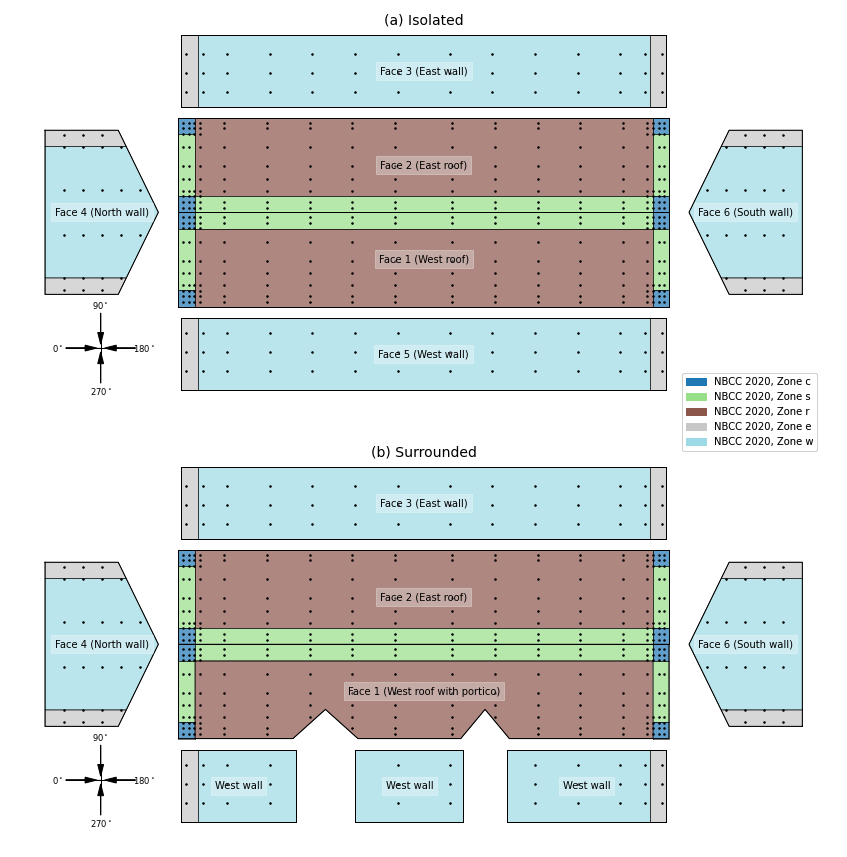

In [15]:
fig = plt.figure(figsize=[12,12])
axs = fig.subplots(2,1)
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

ax = axs[0]
ax.text(0.5, 0.95, r'(a) Isolated', transform=ax.transAxes, ha='center', va='bottom', fontsize=14)
bldg_iso.plotEdges(ax=ax,showName=True)
bldg_iso.plotTaps(ax=ax,showTapNo=False)
# bldg_iso.plotTribs(ax=ax,)
_, legend, _ = bldg_iso.plotZones(ax=ax)
ax.add_artist(legend)
legend.set_bbox_to_anchor((0.81, 0.11))
bldg_iso.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5])
ax.axis('equal')
ax.axis('off')

ax = axs[1]
ax.text(0.5, 0.95, r'(b) Surrounded', transform=ax.transAxes, ha='center', va='bottom', fontsize=14)
bldg_sur.plotEdges(ax=ax,showName=True)
bldg_sur.plotTaps(ax=ax,showTapNo=False)
# bldg_sur.plotTribs(ax=ax,)
bldg_sur.plotZones(ax=ax, showLegend=False)
bldg_sur.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5])
ax.axis('equal')
ax.axis('off')

plt.show()

# # if saveFigs:
# fig.savefig(figDir+"tapLayout_tex.svg",format='svg',dpi=1200, bbox_inches='tight')


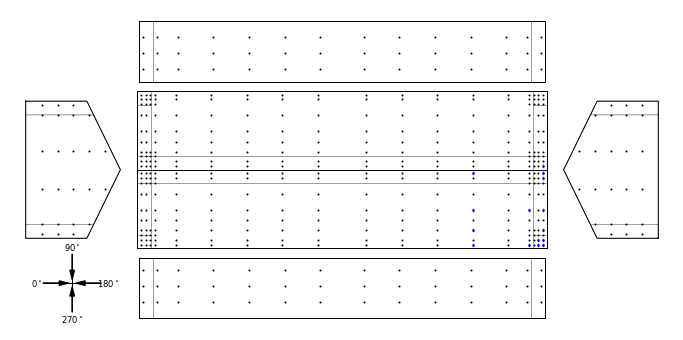

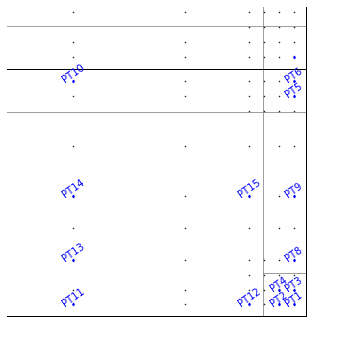

In [16]:
fig = plt.figure(figsize=[12,6])
ax = fig.subplots(1,1)

allTaps = bldg_iso.tapNo
nonFStaps = np.setdiff1d(allTaps, all_fullScaleTaps)

_ = bldg_iso.plotZones(ax=ax, showLegend=False, kwargs_Edge={'color':'gray', 'linewidth':0.5, 'ls':'-'}, 
                                  kwargs_Fill={'alpha':0.0})
bldg_iso.plotTaps(ax=ax,showTapNo=False, tapsToPlot=all_fullScaleTaps,  kwargs_dots={'color':'b', 'markersize':2, 'marker':'d', 'ls':'none'})
bldg_iso.plotTaps(ax=ax,showTapNo=False, tapsToPlot=nonFStaps,          kwargs_dots={'color':'k', 'markersize':2, 'marker':'.', 'ls':'none'})
bldg_iso.plotEdges(ax=ax,showName=False,)
bldg_iso.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5])
ax.axis('equal')
ax.axis('off')
plt.show()
# # if saveFigs:
# fig.savefig(figDir+"tapLayout_simple.svg",format='svg',dpi=1200, bbox_inches='tight')


fig = plt.figure(figsize=[6,6])
ax = fig.subplots(1,1)

_ = bldg_iso.plotZones(ax=ax, showLegend=False, kwargs_Edge={'color':'gray', 'linewidth':0.5, 'ls':'-'}, 
                                  kwargs_Fill={'alpha':0.0})
bldg_iso.plotEdges(ax=ax,showName=False,)
bldg_iso.plotTaps(ax=ax,showTapName=True, tapsToPlot=all_fullScaleTaps, 
                  textOffset_tapName=[0,-1],
                  kwargs_dots={'color':'b', 'markersize':2, 'marker':'d', 'ls':'none'},
                  kwargs_text={'color':'b', 'fontsize':10, 'rotation':35, 'ha':'center', 'va':'bottom', 'backgroundcolor':[1,1,1,0.0]})
bldg_iso.plotTaps(ax=ax,showTapNo=False, tapsToPlot=nonFStaps,          kwargs_dots={'color':'k', 'markersize':1, 'marker':'.', 'ls':'none'})
ax.axis('equal')
ax.axis('off')
ax.set_xlim([120, 210])
ax.set_ylim([-85, 20])
plt.show()

# # if saveFigs:
# fig.savefig(figDir+"tapLayout_simple_zoom.svg",format='svg',dpi=1200, bbox_inches='tight')


In [17]:
print(bldg_iso[1].indexOfTap(2004))
print(bldg_iso[1].tapName.keys()[144])
print(bldg_iso[1].tapName[298])
# print(list(bldg_iso[1].tapName)[153])
# bldg_iso[1].tapName[298] = 'PT7'

[144]
298



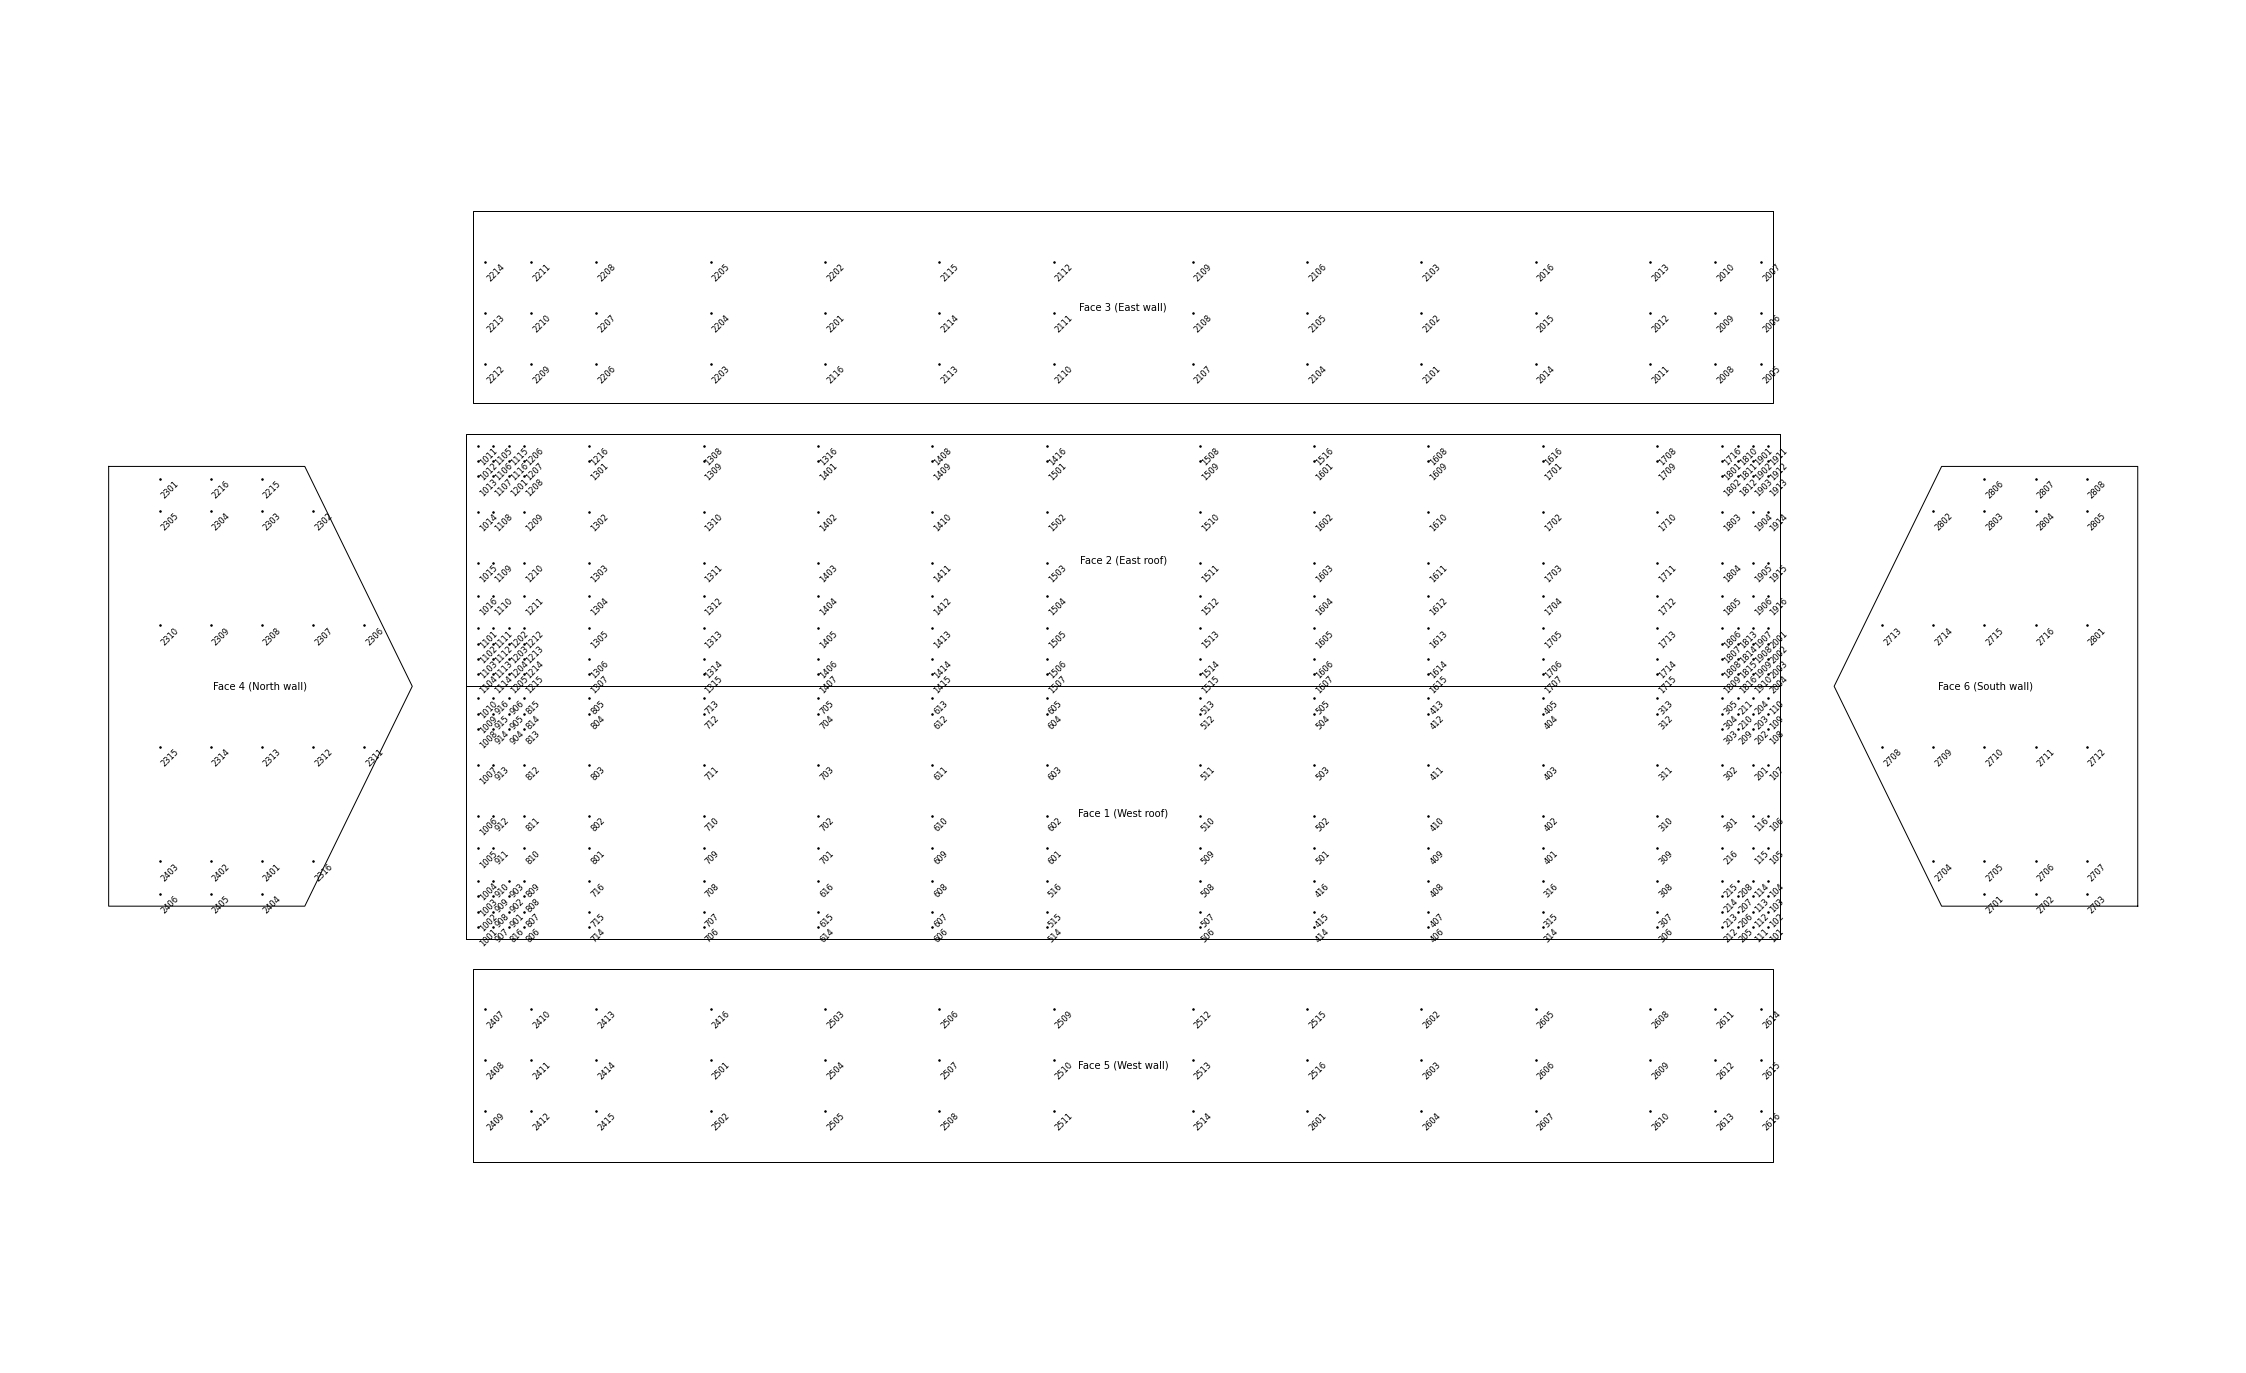

In [18]:
fig = plt.figure(figsize=[40,25])
ax = fig.subplots(1,1)

bldg_iso.plotEdges(ax=ax,showName=True)
bldg_iso.plotTaps(ax=ax,showTapNo=True)

ax.axis('equal')
ax.axis('off')
plt.show()

# if saveFigs:
fig.savefig(figDir+"tapNo.svg",format='svg',dpi=1200, bbox_inches='tight')

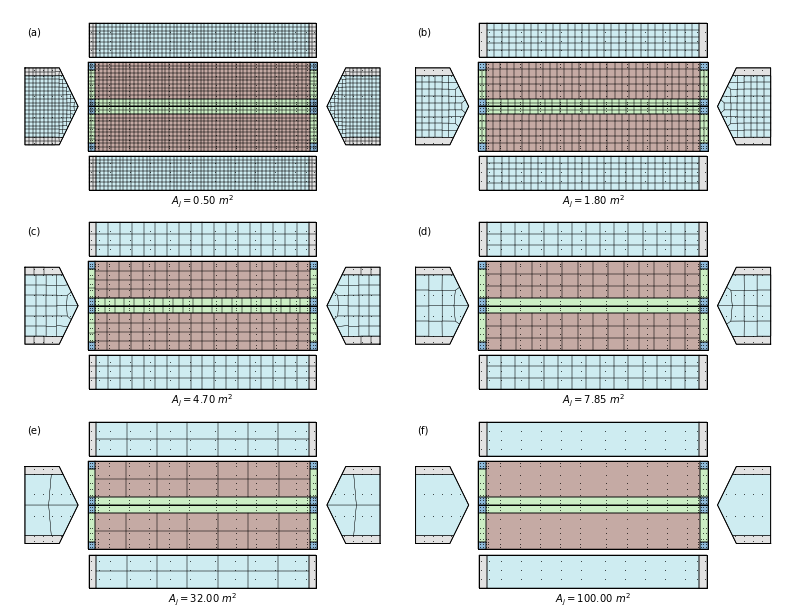

In [19]:
fig, axs = bldg_iso.plotPanels_AllAreas(figsize=[14,11], nCols=2, plotTaps=True,
    areaUnit='$m^2$', areaFactor=areaFactor_toFSm2, areaFmt='{:2.2f}', areaLabel_xy=(0.5,0.025), subPlotLabel_xy=(0.05,0.9),
    kwargs_taps={'kwargs_dots': { 'color': 'k','ls': 'None','marker': '.','markersize': 1.5, 'alpha':1.0, 'markeredgewidth':0.0 }},
    kwargs_zoneEdge={'color':'k', 'linewidth':0.3}
    )
# if saveFigs:
# fig.savefig(figDir+"nominalPanelAreas.svg",format='svg',dpi=1200, bbox_inches='tight')

# <a id='toc4_'></a>[Load and process data](#toc0_)

## <a id='toc4_1_'></a>[Field data](#toc0_)

In [20]:
fieldDataDir = r"D:\tempData_depot\NRC_data\NB_output_final/"
fieldDataFile = fieldDataDir+'NewBrunswick_forPaper1_Stats.xlsx'
figDir2 = r"D:\OneDrive - The University of Western Ontario\Documents\Projects\NRC_fieldMonitoring\NRC_Docs\reports\figures/"

fs_vel = pd.read_excel(fieldDataFile, sheet_name='Velocity', header=0, index_col=0)

fs_meanCp = pd.read_excel(fieldDataFile, sheet_name='meanCp', header=0, index_col=0)

fs_stdCp = pd.read_excel(fieldDataFile, sheet_name='stdCp', header=0, index_col=0)

fs_minPeakCp = pd.read_excel(fieldDataFile, sheet_name='minPeakCp', header=0, index_col=0)

fs_maxPeakCp = pd.read_excel(fieldDataFile, sheet_name='maxPeakCp', header=0, index_col=0)

print(np.shape(fs_meanCp))

AoA = fs_vel['AoA [deg]'] - 5.0  # correct for the 5 deg offset in the field data compared to the wind tunnel data
refH = 1.0

H_FS = 9.81

N_rows = fs_vel.shape[0]

U = fs_vel['U [m/s]'].to_numpy()
cutoff_U = 4.0
# idxs = np.where(U>cutoff_U)[0]
# U = U[idxs]

bad_AoA_ranges = [[5, 40.0],]
idx_accepted = []
for i in range(N_rows):
    if U[i] > cutoff_U:
        AoA_i = AoA[i]
        isBad = False
        for badRange in bad_AoA_ranges:
            if AoA_i >= badRange[0] and AoA_i <= badRange[1]:
                isBad = True
                break
        if not isBad:
            idx_accepted.append(i)
idxs = np.array(idx_accepted)
U = U[idxs]

fieldData = {
    'name': 'Field measurements',
    'AoA':  AoA.to_numpy()[idxs],
    'Z':    [1.0],
    'U':    np.ones(N_rows)[idxs],
    'U_orig': fs_vel['U [m/s]'].to_numpy()[idxs],
    'Iu':   fs_vel['Iu'].to_numpy()[idxs],
    'Iv':   fs_vel['Iv'].to_numpy()[idxs],
    'Iw':   fs_vel['Iw'].to_numpy()[idxs],
    'xLu':  fs_vel['xLu [m]'].to_numpy()[idxs]/H_FS,
    'xLv':  fs_vel['xLv [m]'].to_numpy()[idxs]/H_FS,
    'xLw':  fs_vel['xLw [m]'].to_numpy()[idxs]/H_FS,
    'uw':   fs_vel['uw [(m/s)^2]'].to_numpy()[idxs]/U**2,
    'uv':   fs_vel['uv [(m/s)^2]'].to_numpy()[idxs]/U**2,
    'vw':   fs_vel['vw [(m/s)^2]'].to_numpy()[idxs]/U**2,
}

idxTaps = [all_fullScaleTaps.index(tap) for tap in fullScaleTaps]


fs_CpData = {}
fs_CpData['AoA'] = AoA.to_numpy()[idxs]

val = fs_meanCp.to_numpy()[idxs,:]
fs_CpData['mean'] = val[:,idxTaps]

val = fs_stdCp.to_numpy()[idxs,:]
fs_CpData['std'] = val[:,idxTaps]

val = fs_minPeakCp.to_numpy()[idxs,:]
fs_CpData['peakMin'] = val[:,idxTaps]

val = fs_maxPeakCp.to_numpy()[idxs,:]
fs_CpData['peakMax'] = val[:,idxTaps]

print(np.shape(fs_CpData['mean']))



(45, 15)
(44, 14)


In [111]:
import scipy.io as sio

spectFile = fieldDataDir+'Spect_for_python.mat'
print(spectFile)
spectData = sio.loadmat(spectFile)

print(spectData.keys())
fieldData['n'] = np.squeeze(spectData['f'])
fieldData['Suu'] = np.squeeze(spectData['Suu'])
fieldData['Svv'] = np.squeeze(spectData['Svv'])
fieldData['Sww'] = np.squeeze(spectData['Sww'])
fieldData['rf'] = np.squeeze(spectData['rf'])
fieldData['rSuu'] = np.squeeze(spectData['rSuu'])
fieldData['rSvv'] = np.squeeze(spectData['rSvv'])
fieldData['rSww'] = np.squeeze(spectData['rSww'])

fieldData['rf_avg'] = np.mean(fieldData['rf'], axis=1)
fieldData['rSuu_avg'] = np.mean(fieldData['rSuu'], axis=1)
fieldData['rSvv_avg'] = np.mean(fieldData['rSvv'], axis=1)
fieldData['rSww_avg'] = np.mean(fieldData['rSww'], axis=1)

idx = np.where((fieldData['AoA'] >= 255) & (fieldData['AoA'] < 285))[0]
fieldData_West = fieldData.copy()
fieldData_West['name'] = 'Field data (West)'
keys = ['AoA', 'U', 'U_orig', 'Iu', 'Iv', 'Iw', 'xLu', 'xLv', 'xLw', 'uw', 'uv', 'vw']
for k in keys:
    fieldData_West[k] = fieldData_West[k][idx]
fieldData_West['rf'] = fieldData_West['rf'][:,idx]
fieldData_West['rSuu'] = fieldData_West['rSuu'][:,idx]
fieldData_West['rSvv'] = fieldData_West['rSvv'][:,idx]
fieldData_West['rSww'] = fieldData_West['rSww'][:,idx]
fieldData_West['Suu'] = fieldData_West['Suu'][:,idx]
fieldData_West['Svv'] = fieldData_West['Svv'][:,idx]
fieldData_West['Sww'] = fieldData_West['Sww'][:,idx]
fieldData_West['rf_avg'] = np.mean(fieldData_West['rf'], axis=1)
fieldData_West['rSuu_avg'] = np.mean(fieldData_West['rSuu'], axis=1)
fieldData_West['rSvv_avg'] = np.mean(fieldData_West['rSvv'], axis=1)
fieldData_West['rSww_avg'] = np.mean(fieldData_West['rSww'], axis=1)

idx = np.where((fieldData['AoA'] >= 315) & (fieldData['AoA'] < 345))[0]
fieldData_NNW = fieldData.copy()
fieldData_NNW['name'] = 'Field data (NNW)'
keys = ['AoA', 'U', 'U_orig', 'Iu', 'Iv', 'Iw', 'xLu', 'xLv', 'xLw', 'uw', 'uv', 'vw']
for k in keys:
    fieldData_NNW[k] = fieldData_NNW[k][idx]
fieldData_NNW['rf'] = fieldData_NNW['rf'][:,idx]
fieldData_NNW['rSuu'] = fieldData_NNW['rSuu'][:,idx]
fieldData_NNW['rSvv'] = fieldData_NNW['rSvv'][:,idx]
fieldData_NNW['rSww'] = fieldData_NNW['rSww'][:,idx]
fieldData_NNW['Suu'] = fieldData_NNW['Suu'][:,idx]
fieldData_NNW['Svv'] = fieldData_NNW['Svv'][:,idx]
fieldData_NNW['Sww'] = fieldData_NNW['Sww'][:,idx]
fieldData_NNW['rf_avg'] = np.mean(fieldData_NNW['rf'], axis=1)
fieldData_NNW['rSuu_avg'] = np.mean(fieldData_NNW['rSuu'], axis=1)
fieldData_NNW['rSvv_avg'] = np.mean(fieldData_NNW['rSvv'], axis=1)
fieldData_NNW['rSww_avg'] = np.mean(fieldData_NNW['rSww'], axis=1)

print(np.shape(fieldData['n']))
print(np.shape(fieldData['Suu']))
print(np.shape(fieldData_West['rf']))

print(f"Avg. turbulence intensity NW: {np.mean(fieldData_NNW['Iu'])*100:.2f} %")

D:\tempData_depot\NRC_data\NB_output_final/Spect_for_python.mat
dict_keys(['__header__', '__version__', '__globals__', 'Suu', 'Svv', 'Sww', 'f', 'rSuu', 'rSvv', 'rSww', 'rf'])
(1025,)
(1025, 45)
(1025, 23)
Avg. turbulence intensity NW: 32.86 %


In [121]:
z0_W=0.68  # based on literature estimate
# z0_W=0.42
zd_W = 4.76
Z = np.logspace(np.log10(zd_W), np.log10(300.0), 100)
es85_Fld_W = wind.ESDU85(Z=Z, z0=z0_W,
                       Zref=H_FS, 
                       Uref=np.mean(fieldData_West['U']))
es85_Fld_W_obj = es85_Fld_W.toProfileObj()
es85_Fld_W_obj.name = r'ESDU ($z_0='+f"{z0_W:.2g}"+'m, z_d='+f'{zd_W:.2g}'+'m$)'
es85_Fld_W_obj.SpectH.name = r'ESDU ($z_0='+f"{z0_W:.2g}"+'m, z_d='+f'{zd_W:.2g}'+'m$)'
print(f"TI from field = {np.mean(fieldData_West['Iu'])*100:.2f} %")
print(f"TI from ESDU = {es85_Fld_W_obj.SpectH.Iu*100:.2f} %")

# z0_NNW=0.52 # based on literature estimate
z0_NNW=0.385
zd_NNW = 3.9
Z = np.logspace(np.log10(zd_NNW), np.log10(300.0), 100)
es85_Fld_NNW = wind.ESDU85(Z=Z, z0=z0_NNW,
                          Zref=H_FS, 
                          Uref=np.mean(fieldData_NNW['U']))
es85_Fld_NNW_obj = es85_Fld_NNW.toProfileObj()
es85_Fld_NNW_obj.name = r'ESDU ($z_0='+f"{z0_NNW:.2g}"+'m, z_d='+f'{zd_NNW:.2g}'+'m$)'
es85_Fld_NNW_obj.SpectH.name = r'ESDU ($z_0='+f"{z0_NNW:.2g}"+'m, z_d='+f'{zd_NNW:.2g}'+'m$)'
print(f"TI from field = {np.mean(fieldData_NNW['Iu'])*100:.2f} %")
print(f"TI from ESDU = {es85_Fld_NNW_obj.SpectH.Iu*100:.2f} %")

es85_Fld_mnl = wind.ESDU85(z0=1.0,
                          Zref=H_FS,
                          Uref=25, #np.mean(fieldData['U']),
                          )
es85_Fld_mnl_obj = es85_Fld_mnl.toProfileObj()
es85_Fld_mnl_obj.name = f'ESDU ($z_0={es85_Fld_mnl_obj.z0_Iu:.2g}$ m)'
es85_Fld_mnl_obj.SpectH.name = f'ESDU ($z_0={es85_Fld_mnl_obj.z0_Iu:.2g}$ m)'
print(f"TI from field = {np.mean(fieldData['Iu'])*100:.2f} %")
print(f"TI from ESDU = {es85_Fld_mnl_obj.SpectH.Iu*100:.2f} %")

# ess = wind.Profiles([es85_Fld_W_obj, es85_Fld_NNW_obj])
# _ = ess.plotProfile_basic2(yLimits=[0,10])

Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=0.68 m$). Skipping velocity statistics calculation.
TI from field = 39.32 %
TI from ESDU = 39.18 %
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=0.385 m$). Skipping velocity statistics calculation.
TI from field = 32.86 %
TI from ESDU = 32.88 %
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=1 m$). Skipping velocity statistics calculation.
TI from field = 36.74 %
TI from ESDU = 36.01 %


## <a id='toc4_2_'></a>[Wind tunnel](#toc0_)


### <a id='toc4_2_1_'></a>[Wind field](#toc0_)

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:769: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:3138: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=0.0137 m$). Skipping velocity statistics calculation.
No velocity time history found for ESDU-85 ($z_0=0.00179 m$). Skipping velocity statistics calculation.
Fitted z0 = 0.015m @FS


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:769: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:3138: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=0.146 m$). Skipping velocity statistics calculation.
No velocity time history found for ESDU-85 ($z_0=0.0302 m$). Skipping velocity statistics calculation.
Fitted z0 = 0.15m @FS


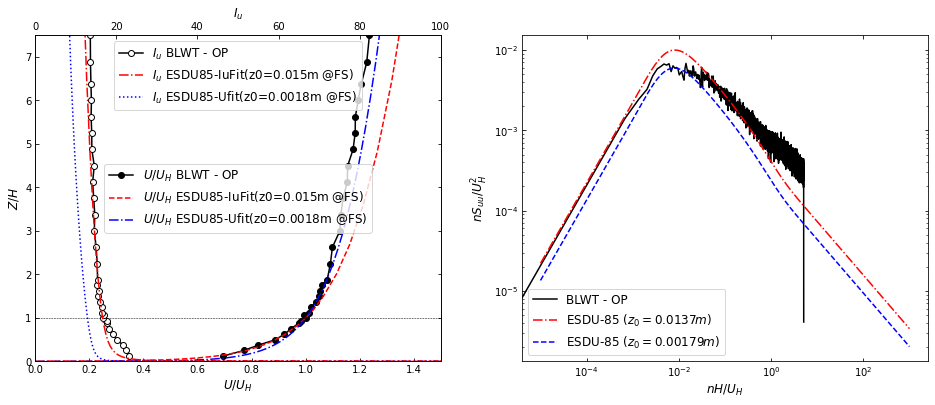

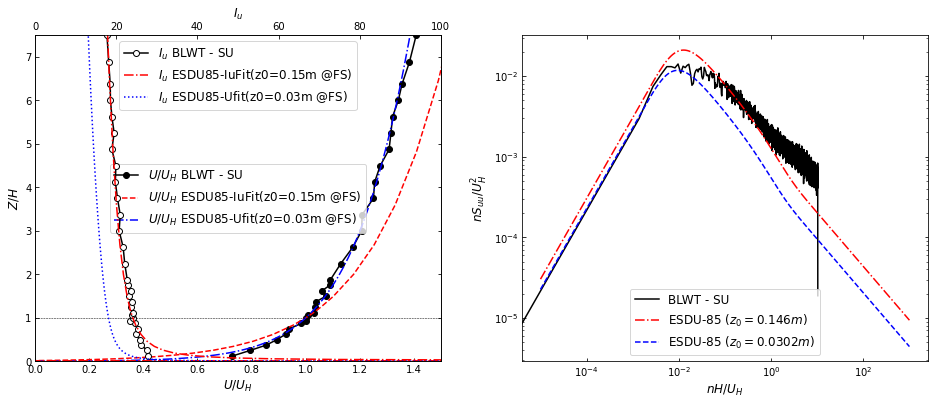

In [23]:
sFreq = 1600
dt = 1/sFreq

pDir =profileDir+"tngE2/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")*-1
W_TH = np.load(pDir+"WofT.npy")*-1
vel_OP = wind.profile(name="BLWT - OP", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=32, workSect_zLim = [0, 0.6], lScl=lScl, 
                      keepTH=True)
vel_OP.fit_z0(debugMode=True,)

pDir =profileDir+"tngE3/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")*-1
W_TH = np.load(pDir+"WofT.npy")*-1
vel_SU = wind.profile(name="BLWT - SU", Z=Z,UofT=U_TH.transpose(),VofT=V_TH.transpose(),WofT=W_TH.transpose(),H=H,dt=dt,nSpectAvg=32,workSect_zLim = [0, 0.6], lScl=lScl,
                      keepTH=True)
vel_SU.fit_z0(debugMode=True,)

del(U_TH, V_TH, W_TH)

In [24]:
# if exp == 'E2':
#     vel_WT = vel_OP
# elif exp == 'E3':
#     vel_WT = vel_SU
z0_OP = 0.015
z0_SU = 0.15

es85_OP = wind.ESDU85(z0=z0_OP, Zref=H/lScl, Uref=25.0, phi=site_latitude)
es74_OP = wind.ESDU74(z0=z0_OP, Zref=H/lScl, Uref=25.0, phi=site_latitude)
vel_E2_ESDU = es85_OP.toProfileObj()
vel_E2_ESDU.SpectH = es74_OP.toProfileObj().SpectH
vel_E2_ESDU.name = r'ESDU ($z_0='+f"{z0_OP:.2g}"+'m$)'
vel_E2_ESDU.SpectH.name = r'ESDU ($z_0='+f"{z0_OP:.2g}"+'m$)'

es85_SU = wind.ESDU85(z0=z0_SU, Zref=H/lScl, Uref=25.0, phi=site_latitude)
es74_SU = wind.ESDU74(z0=z0_SU, Zref=H/lScl, Uref=25.0, phi=site_latitude)
vel_E3_ESDU = es85_SU.toProfileObj()
vel_E3_ESDU.SpectH = es74_SU.toProfileObj().SpectH
vel_E3_ESDU.name = r'ESDU ($z_0='+f"{z0_SU:.2g}"+'m$)'
vel_E3_ESDU.SpectH.name = r'ESDU ($z_0='+f"{z0_SU:.2g}"+'m$)'

# vel = wind.Profiles([vel_OP, vel_SU, es74_OP.toProfileObj(), es85_OP.toProfileObj(), es74_SU.toProfileObj(), es85_SU.toProfileObj(),])
vel = wind.Profiles([vel_OP, vel_SU, vel_E2_ESDU, vel_E3_ESDU,])
vel_OP_all = wind.Profiles([vel_OP, es74_OP.toProfileObj(), es85_OP.toProfileObj(),])
vel_SU_all = wind.Profiles([vel_SU, es74_SU.toProfileObj(), es85_SU.toProfileObj(),])

Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
Message from ESDU74: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=0.015 m$). Skipping velocity statistics calculation.
No velocity time history found for ESDU-74 ($z_0=0.015 m$). Skipping velocity statistics calculation.
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
Message from ESDU74: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=0.15 m$). Skipping velocity statistics calculation.
No velocity time history found for ESDU-74 ($z_0=0.15 m$). Skipping velocity statistics calculation.
No velocity time history found for ESDU-74 ($z_0=0.015 m$). Skipping velocity statistics cal

### <a id='toc4_2_2_'></a>[Pressure](#toc0_)

In [25]:
analogChannels_idxs={
                'main_pitot': 0,
                'xcheck_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 2909,
                'main_pitot_queue': 2910,
                '20inch_pitot_zero': 2907,
                '20inch_pitot_queue': 2908,
                'Uh_pitot_zero': 2905,
                'Uh_pitot_queue': 2906,
            }

peakSpecs = wind.DEFAULT_PEAK_SPECS
peakSpecs['Num_seg'] = 10
peakSpecs['Duration'] = 10
peakSpecs['prob_non_excd'] = 0.8

Re-scaling profile to match Uref ...
    Uref_avg = 12.149 m/s
    U_ref_prof = 12.542 m/s
    U_ratio = 0.969
    time_ratio = 1.032
Refreshing BLWT-OP-iso...
Verifying data ...
Computing Cp statistics ...
Computing area-averaging ...
    Computing area-averaging for face Face 1 (West roof) ...
    Computing area-averaging for face Face 2 (East roof) ...
    Computing area-averaging for face Face 3 (East wall) ...
    Computing area-averaging for face Face 4 (North wall) ...
    Computing area-averaging for face Face 5 (West wall) ...
    Computing area-averaging for face Face 6 (South wall) ...
Done refreshing BLWT-OP-iso.

Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
No velocity time history fou

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:769: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:3138: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


Reading HFPI data from: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E3/
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E3/TSINUELc2E03R001P001a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E3/TSINUELc2E03R001P002a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E3/TSINUELc2E03R001P003a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E3/TSINUELc2E03R001P004a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E3/TSINUELc2E03R001P005a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E3/TSINUELc2E03R001P006a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E3/TSINUELc2E03R001P007a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E3/TSINUELc2E03R001P008a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E3/TSINUELc2E03R001P009a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E3/TSINUELc2E03R001P010a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E3/TSINUELc2E03R0

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:769: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:3138: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


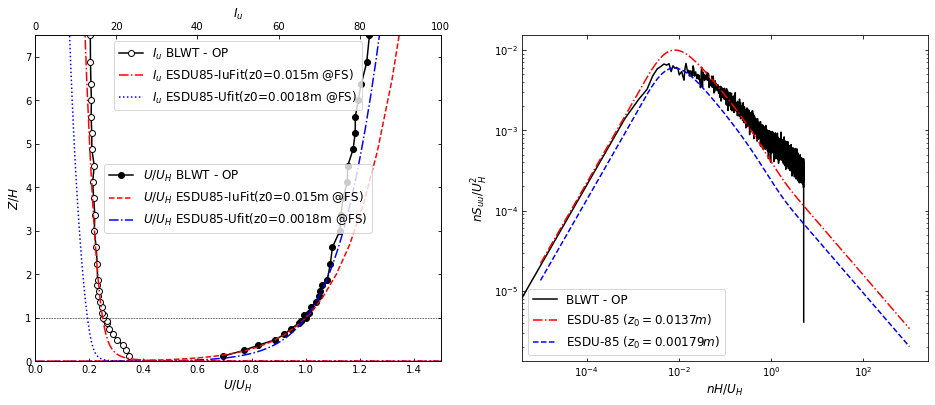

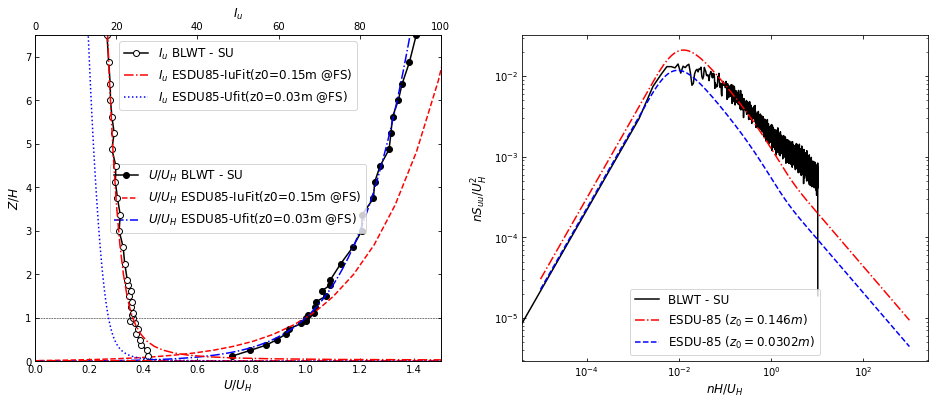

In [31]:
cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir_iso_OP,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    Ntaps=440,
    trimTimeStart=0,
    trimTimeEnd=dur_MS_1hr,
)
winsound.Beep(1000, 1000)


s, e = cp_raw.trimTimeStartIdx, cp_raw.trimTimeEndIdx
cp_iso_OP = wind.bldgCp(
                bldgName=bldg_iso.name,
                faces=bldg_iso.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg_iso.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg_iso.AoA_rotation_direction,
                # caseName=caseName_iso_OP,
                caseName='BLWT-OP-iso',
                refProfile=vel_OP,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                # Uref_FS=ve
                vScl=vScl,
                samplingFreq=cp_raw.sampleRate,
                notes_Cp=cp_raw.description,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH[:,:,s:e],
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
cp_iso_OP.profile.fit_z0()
winsound.Beep(1000, 1000)

cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir_iso_SU,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    Ntaps=440,
    trimTimeStart=0,
    trimTimeEnd=dur_MS_1hr,
)
winsound.Beep(1000, 1000)

s, e = cp_raw.trimTimeStartIdx, cp_raw.trimTimeEndIdx
cp_iso_SU = wind.bldgCp(
                bldgName=bldg_iso.name,
                faces=bldg_iso.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg_iso.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg_iso.AoA_rotation_direction,
                # caseName=caseName_iso_SU,
                caseName='BLWT-SU-iso',
                refProfile=vel_SU,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                vScl=vScl,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH[:,:,s:e],
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
cp_iso_SU.profile.fit_z0()
winsound.Beep(1000, 1000)


Reading HFPI data from: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P001a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P002a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P003a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P004a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P005a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P006a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P007a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P008a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P009a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P010a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R0

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:769: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:3138: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


Reading HFPI data from: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E3/
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E3/TSINUELc1E03R001P001a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E3/TSINUELc1E03R001P002a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E3/TSINUELc1E03R001P003a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E3/TSINUELc1E03R001P004a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E3/TSINUELc1E03R001P005a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E3/TSINUELc1E03R001P006a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E3/TSINUELc1E03R001P007a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E3/TSINUELc1E03R001P008a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E3/TSINUELc1E03R001P009a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E3/TSINUELc1E03R001P010a.pssd
   Reading file: F:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E3/TSINUELc1E03R0

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:769: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:3138: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


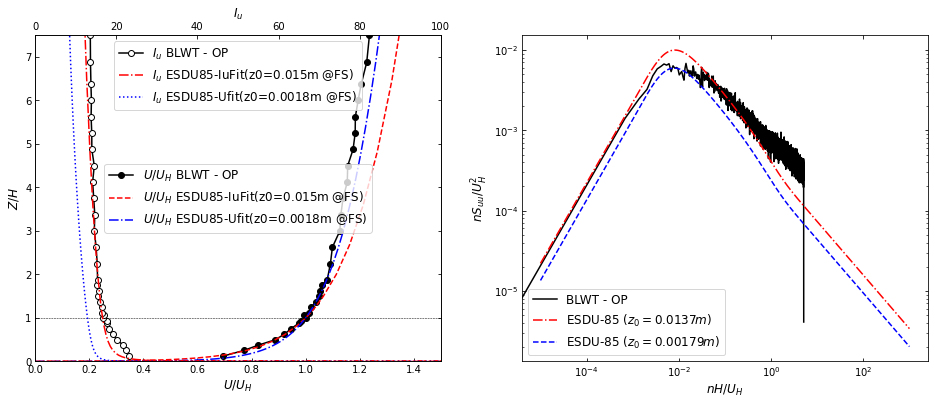

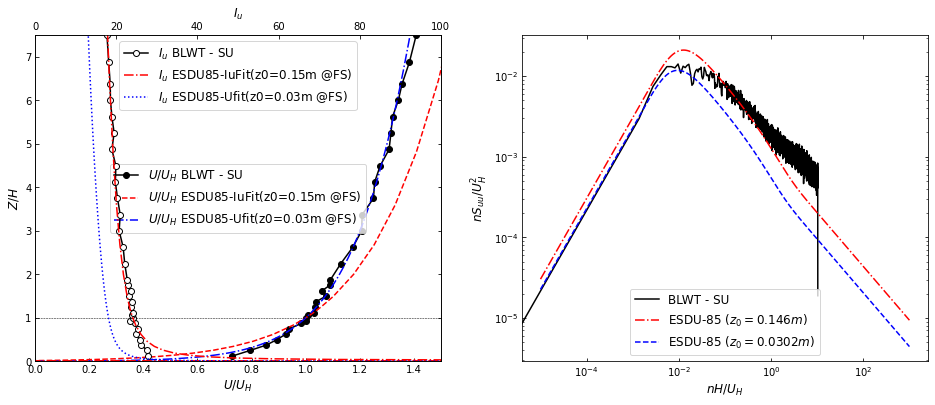

In [32]:
cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir_sur_OP,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    Ntaps=440,
    trimTimeStart=0.0,
    trimTimeEnd=dur_MS_1hr,    
)
winsound.Beep(1000, 1000)

s, e = cp_raw.trimTimeStartIdx, cp_raw.trimTimeEndIdx
cp_sur_OP = wind.bldgCp(
                bldgName=bldg_sur.name,
                faces=bldg_sur.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg_sur.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg_sur.AoA_rotation_direction,
                # caseName=caseName_sur_OP,
                caseName='BLWT-OP-sur',
                refProfile=vel_OP,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                vScl=vScl,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH[:,:,s:e],
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
cp_sur_OP.profile.fit_z0()
winsound.Beep(1000, 1000)

cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir_sur_SU,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    Ntaps=440,
    trimTimeStart=0.0,
    trimTimeEnd=dur_MS_1hr,
)
winsound.Beep(1000, 1000)

s, e = cp_raw.trimTimeStartIdx, cp_raw.trimTimeEndIdx
cp_sur_SU = wind.bldgCp(
                bldgName=bldg_sur.name,
                faces=bldg_sur.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg_sur.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg_sur.AoA_rotation_direction,
                # caseName=caseName_sur_SU,
                caseName='BLWT-SU-sur',
                refProfile=vel_SU,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                vScl=vScl,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH[:,:,s:e],
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
cp_sur_SU.profile.fit_z0()
winsound.Beep(1000, 1000)

# <a id='toc5_'></a>[Plot results](#toc0_)

### <a id='toc5_1_1_'></a>[Field data only](#toc0_)

#### <a id='toc5_1_1_1_'></a>[Field data wind rose](#toc0_)

Angle range 	 Mean wind speed [m/s] 	 Turbulence intensity [%] 	 No. of segments
15.0-45.0 	 nan 				 nan 				 0
45.0-75.0 	 5.4 				 36.5 				 2
75.0-105.0 	 nan 				 nan 				 0
105.0-135.0 	 nan 				 nan 				 0
135.0-165.0 	 nan 				 nan 				 0
165.0-195.0 	 nan 				 nan 				 0
195.0-225.0 	 4.6 				 28.7 				 2
225.0-255.0 	 4.8 				 34.4 				 8
255.0-285.0 	 5.0 				 39.3 				 23
285.0-315.0 	 5.2 				 38.1 				 2
315.0-345.0 	 8.3 				 32.9 				 7
345.0-375.0 	 nan 				 nan 				 0
Figure saved as D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/gable27deg/__plots/windRose.svg


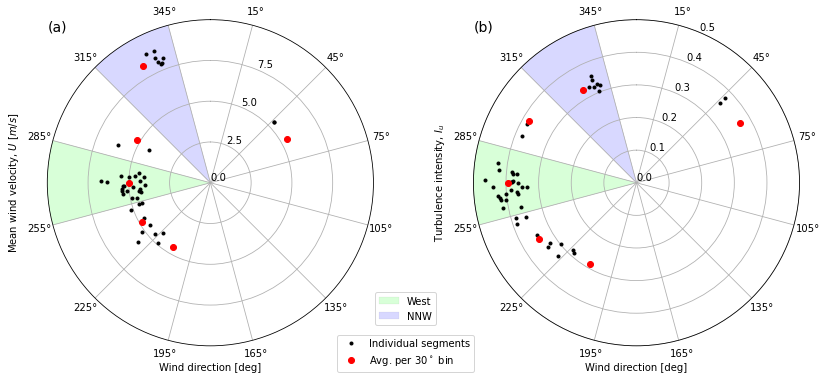

In [116]:

# Example data (wind directions in degrees, and wind speeds in m/s)
aoa = fieldData['AoA']
U = fieldData['U_orig']


# plt.polar(np.radians(fieldData['AoA']), fieldData['U'], 'k.')
# # set the limits
# # plt.ylim(0, 1.5)

# plt.plot(fieldData['AoA'],'.k')

# divide AoA into 16 bins
nBins = 12
binEdges = np.linspace(15,375,nBins+1)
binCenters = (binEdges[1:] + binEdges[:-1])/2
binWidth = binEdges[1] - binEdges[0]
binCounts = np.zeros(nBins)
binCounts_weighted = np.zeros(nBins)
binIndices = np.zeros(len(aoa), dtype=int)
for i in range(nBins):
    idx = np.where((aoa >= binEdges[i]) & (aoa < binEdges[i+1]))[0]
    binCounts[i] = len(idx)
    binCounts_weighted[i] = np.sum(U[idx])
    binIndices[idx] = i
binCounts = binCounts/np.sum(binCounts)*100
binCounts_weighted = binCounts_weighted/np.sum(binCounts_weighted)*100

# # plot the histogram
# fig, axs = plt.subplots(1,1,figsize=[13,6], subplot_kw={'projection': 'polar'})
# ax = axs
# ax.bar(np.radians(binCenters), binCounts_weighted, width=np.radians(binWidth), color='b', edgecolor='k', alpha=0.5, linewidth=2.0)
# ax.set_theta_zero_location("N")
# ax.set_theta_direction(-1)
# # ax.set_ylim([0,60])
# ax.set_xticks(np.radians(np.arange(15,346,30)))
# # ax.set_yticks(np.arange(0,61,10))
# ax.set_xlabel('Wind direction [deg]')
# ax.set_title('Frequency [%]')
# ax.yaxis.set_label_coords(-0.08,0.5)
# ax.grid(True)

# plot the mean wind speed per bin
binSpeeds = np.zeros(nBins)
bin_Iu = np.zeros(nBins)
bin_Iv = np.zeros(nBins)
bin_Iw = np.zeros(nBins)

print(f"Angle range \t Mean wind speed [m/s] \t Turbulence intensity [%] \t No. of segments")
for i in range(nBins):
    idx = np.where(binIndices == i)[0]
    binSpeeds[i] = np.mean(U[idx]) if len(idx) > 0 else np.nan
    bin_Iu[i] = np.mean(fieldData['Iu'][idx]) if len(idx) > 0 else np.nan
    bin_Iv[i] = np.mean(fieldData['Iv'][idx]) if len(idx) > 0 else np.nan
    bin_Iw[i] = np.mean(fieldData['Iw'][idx]) if len(idx) > 0 else np.nan
    print(f"{binEdges[i]:.1f}-{binEdges[i+1]:.1f} \t {binSpeeds[i]:.1f} \t\t\t\t {bin_Iu[i]*100:.1f} \t\t\t\t {len(idx)}")


fig, axs = plt.subplots(1,2,figsize=[14,6], subplot_kw={'projection': 'polar'})
ax = axs[0]  # mean wind speed
ax.bar(np.radians(270), 20, width=np.radians(30), color=[0.5,1,0.5], edgecolor='k', alpha=0.3, linewidth=0.1)
ax.bar(np.radians(330), 20, width=np.radians(30), color=[0.5,0.5,1], edgecolor='k', alpha=0.3, linewidth=0.1)
ax.plot(np.radians(fieldData['AoA']), fieldData['U_orig'], '.', color='k', linewidth=2.0, label='Individual segments')
ax.plot(np.radians(binCenters), binSpeeds, 'ro', linewidth=4.0, label=r'Avg. per $30^\circ$ bin')
ax.text(0.0, 1.0, '(a)', transform=ax.transAxes, fontsize=14, va='top')
ax.legend(bbox_to_anchor=(1.325, 0.05), )
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_ylim([0,10])
ax.set_xticks(np.radians(np.arange(15,346,30)))
ax.set_yticks(np.arange(0,10,2.5))
ax.yaxis.set_label_coords(-0.08,0.5)
ax.set_xlabel('Wind direction [deg]')
ax.set_ylabel(r'Mean wind velocity, $U$ [$m/s$]')
# ax.set_title(r'Wind rose of extracted segments from the New Brunswick field data')
# move location of title to top center of the full figure
ttl = ax.title
ttl.set_position([1.1, 1.1])


ax.grid(True)
# move the y-axis label away from the plot

ax = axs[1]  # Turbulence intensity, Iu
ax.bar(np.radians(270), 20, width=np.radians(30), color=[0.5,1,0.5], edgecolor='k', alpha=0.3, linewidth=0.1, label='West')
ax.bar(np.radians(330), 20, width=np.radians(30), color=[0.5,0.5,1], edgecolor='k', alpha=0.3, linewidth=0.1, label='NNW')
ax.plot(np.radians(fieldData['AoA']), fieldData['Iu'], '.', color='k', linewidth=2.0,)# label='All segments')
ax.plot(np.radians(binCenters), bin_Iu, 'ro', linewidth=4.0,)# label=r'Avg. per $30^\circ$ bin')
ax.text(0.0, 1.0, '(b)', transform=ax.transAxes, fontsize=14, va='top')
ax.legend(bbox_to_anchor=(-0.1, 0.18))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_ylim([0,0.5])
ax.set_xticks(np.radians(np.arange(15,346,30)))
ax.set_yticks(np.arange(0,0.51,0.1))
ax.yaxis.set_label_coords(-0.08,0.5)
ax.set_xlabel('Wind direction [deg]')
ax.set_ylabel(r'Turbulence intensity, $I_u$')
# ax.set_title(r'Turbulence intensity ($255^\circ$ to $285^\circ$)')
ax.grid(True)

if saveFigs:
    fig.savefig(figDir+"windRose.svg",format='svg',dpi=1200, bbox_inches='tight')
    print('Figure saved as '+figDir+"windRose.svg")


In [35]:
Iu = [32.9, 39.3]
z0 = [0.38,0.68]
zd = [3.9,4.8]

Iu2 = [34.4,36.5,38.1]
z02 = np.interp(Iu2, Iu, z0)
zd2 = np.interp(Iu2, Iu, zd)

# extrapolate
Iu3 = [28.7,] 
from scipy.interpolate import interp1d
f = interp1d(Iu, z0, kind='linear', fill_value='extrapolate')
z03 = f(Iu3)
f = interp1d(Iu, zd, kind='linear', fill_value='extrapolate')
zd3 = f(Iu3)

Iu.extend(Iu2)
Iu.extend(Iu3)
z0.extend(z02)
z0.extend(z03)
zd.extend(zd2)
zd.extend(zd3)

z0es = [0.38, 0.68, 0.45, 0.55, 0.62, 0.24]

print(f"Iu \t Iu(es)\t z0 \t z0(es)\t z_d")
for iu, z0i, z0e, zdi in zip(Iu, z0, z0es, zd):
    Z = np.logspace(np.log10(zdi), np.log10(300.0), 100)
    es = wind.ESDU85(Z=Z, z0=z0e,
                            Zref=H_FS, 
                            Uref=np.mean(fieldData_West['U']))
    es_obj = es.toProfileObj()
    print(f"{iu:.1f} \t {es_obj.SpectH.Iu*100:.1f} \t {z0i:.2f} \t {es.z0:.2f} \t {zdi:.1f}")


Iu 	 Iu(es)	 z0 	 z0(es)	 z_d
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=0.38 m$). Skipping velocity statistics calculation.
32.9 	 32.8 	 0.38 	 0.38 	 3.9
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=0.68 m$). Skipping velocity statistics calculation.
39.3 	 39.2 	 0.68 	 0.68 	 4.8
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=0.45 m$). Skipping velocity statistics calculation.
34.4 	 34.4 	 0.45 	 0.45 	 4.1
Message from ESDU85: Functionality for zero-plane displacement i

In [36]:
# # plot wind rose of the field data using circular bins
# fig = plt.figure(figsize=[12,12])
# ax = fig.subplots(1,1)
# fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

# nBins = 16
# binEdges = np.linspace(0,360,nBins+1)
# binCenters = (binEdges[1:] + binEdges[:-1])/2
# binWidth = binEdges[1] - binEdges[0]
# binCounts = np.zeros(nBins)
# for i in range(nBins):
#     idx = np.where((AoA >= binEdges[i]) & (AoA < binEdges[i+1]))[0]
#     binCounts[i] = len(idx)
# binCounts = binCounts/np.sum(binCounts)*100

# ax.bar(binCenters, binCounts, width=binWidth, color='k', edgecolor='k', alpha=0.5)  
# ax.set_xlim([0,360])
# ax.set_ylim([0,20])
# ax.set_xticks(np.arange(0,361,45))
# ax.set_yticks(np.arange(0,21,5))
# ax.set_xlabel('Wind direction [deg]')
# ax.set_ylabel('Frequency [%]')
# ax.set_title('Field data')
# ax.grid(True)

### <a id='toc5_1_2_'></a>[Wind field](#toc0_)
#### <a id='toc5_1_2_1_'></a>[All profiles](#toc0_)

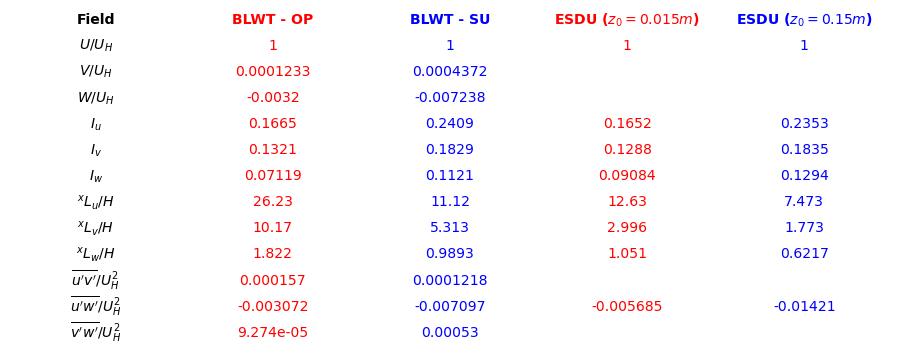

Message from Profiles.plotProfile_basic2(): Future feature notice: a table of normalizers like H, Uref, etc. next to the legend.
          Location: D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py
          Function: plotProfile_basic2
          Line number: 5096


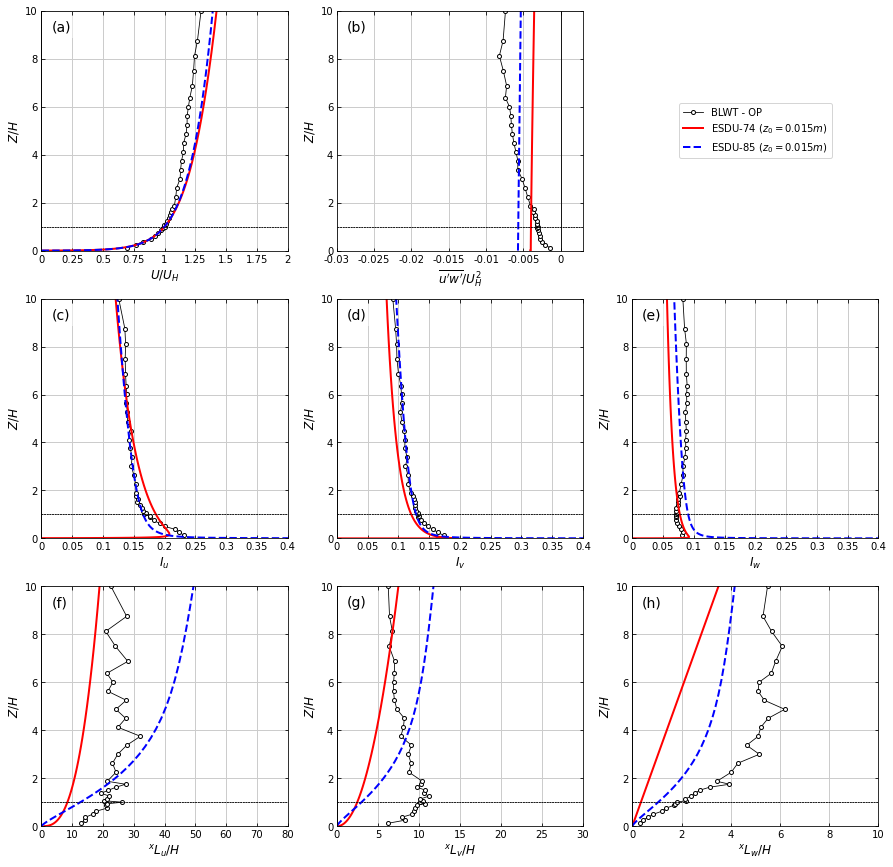

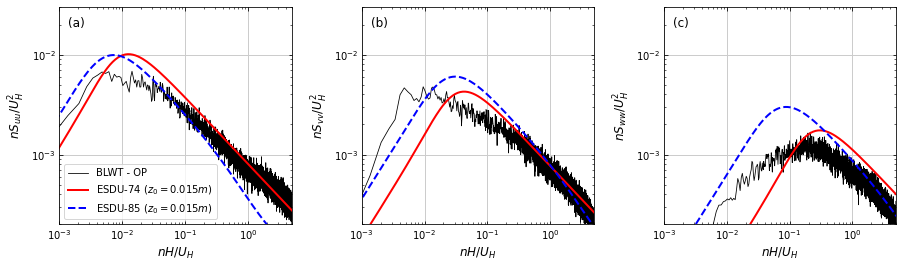

In [37]:
fig, _ = vel.plotRefHeightStatsTable(fontSz=14,figWidthFctr=0.9,
                                     colTxtColors=['r','b','r','b','b','c','r','b','c'],)
# fig.savefig(direct+'kate_refHeightStatsTable.svg', dpi=300, bbox_inches='tight')

kwargs_plt=[{'lw':0.8, 'ls':'-', 'color':'k', 'marker':'o', 'ms':4, 'mfc':'w', }, 
            # {'lw':0.8, 'ls':'-', 'color':'b', 'marker':'d', 'ms':4, 'mfc':'w', },
            {'lw':2, 'ls':'-', 'color':'r'},
            {'lw':2, 'ls':'--', 'color':'b'},
            {'lw':2, 'ls':'-', 'color':'c'},
            {'lw':2, 'ls':'--', 'color':'r'},
            {'lw':2, 'ls':'--', 'color':'b'},
            {'lw':2, 'ls':'--', 'color':'c'},
            ]

fig, _ = vel_OP_all.plotProfile_basic2(figsize=[15,15],
                        yLimits=[0,10],
                        xLimits_U=[0, 2], xLimits_uw=[-0.03, 0.003],
                        xLimits_Iu=[0,0.4], xLimits_Iv=[0,0.4], xLimits_Iw=[0,0.4],
                        xLimits_xLu=[0, 80], xLimits_xLv=[0,30], xLimits_xLw=[0,10],
                        kwargs_plt=kwargs_plt,
                        )
# fig.savefig(direct+'kate_profile_basic2.svg', dpi=300, bbox_inches='tight')

kwargs_sp_plt=[ {'lw':0.8, 'ls':'-', 'color':'k', 'marker':'None', 'ms':4, 'mfc':'w', }, 
                # {'lw':0.8, 'ls':'--', 'color':'b', 'marker':'None', 'ms':4, 'mfc':'w', }, 
                {'lw':2, 'ls':'-', 'color':'r'},
                {'lw':2, 'ls':'--', 'color':'b'},
                {'lw':2, 'ls':'-', 'color':'c'},
                {'lw':2, 'ls':'--', 'color':'r'},
                {'lw':2, 'ls':'--', 'color':'b'},
                {'lw':2, 'ls':'--', 'color':'c'},
                ]
fig = vel_OP_all.plotSpectra(figsize=[15,4], xLimits=[1e-3,5],
                yLimits=[[2e-4,3e-2],[2e-4,3e-2],[2e-4,3e-2]],
                kwargs_plt=kwargs_sp_plt,)
# fig.savefig(direct+'kate_spectra.svg', dpi=300, bbox_inches='tight')

#### <a id='toc5_1_2_2_'></a>[Selected profiles and spectra](#toc0_)

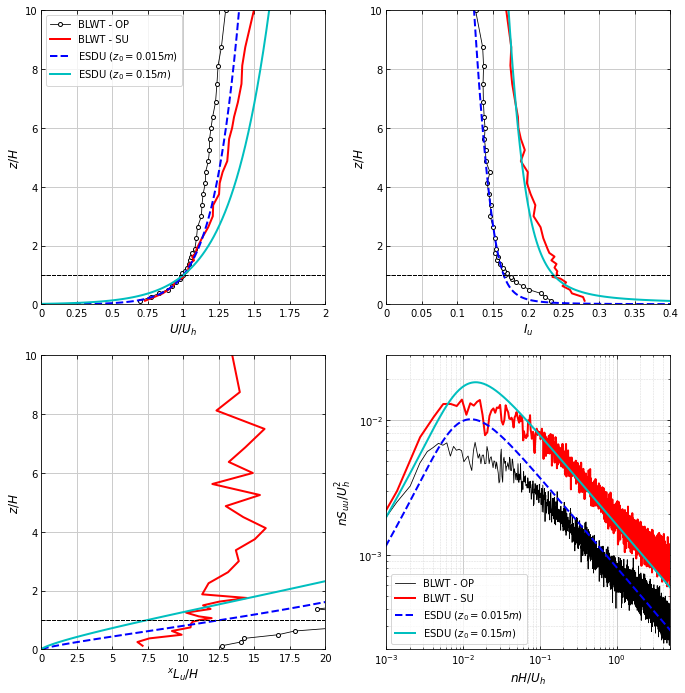

In [38]:
fig, axs = plt.subplots(2,2,figsize=[10,10])
# tight_layout
fig.tight_layout(pad=3.0)

def custom_format(x, pos):
    return f"{x:g}"  # Format the value with 2 decimal places and add ° symbol

kwargs_hline = {'color':'k', 'lw':1.0, 'ls':'--'}
for i, prof in enumerate(vel.profiles):
    ax = axs[0,0]
    ax.plot(prof.UbyUh, prof.ZbyH, label=prof.name, **kwargs_plt[i])
    ax.axhline(1.0, **kwargs_hline)
    ax.legend()
    ax.set_xlabel(r'$U/U_h$')
    ax.set_ylabel(r'$z/H$')
    ax.set_xlim([0,2])
    ax.set_ylim([0,10])
    wind.formatAxis(ax, gridMajor=True, gridMinor=True)

    ax = axs[0,1]
    ax.plot(prof.Iu, prof.ZbyH, **kwargs_plt[i])
    ax.axhline(1.0, **kwargs_hline)
    ax.set_xlabel(r'$I_u$')
    ax.set_ylabel(r'$z/H$')
    ax.set_xlim([0,0.4])
    ax.set_ylim([0,10])
    wind.formatAxis(ax, gridMajor=True, gridMinor=True)

    ax = axs[1,0]
    ax.plot(prof.xLuByH, prof.ZbyH, **kwargs_plt[i])
    ax.axhline(1.0, **kwargs_hline)
    ax.set_xlabel(r'$^xL_u/H$')
    ax.set_ylabel(r'$z/H$')
    ax.set_xlim([0,20])
    ax.set_ylim([0,10])
    wind.formatAxis(ax, gridMajor=True, gridMinor=True)

    ax = axs[1,1]
    ax.loglog(prof.SpectH.rf(), prof.SpectH.rSuu(), label=prof.name, **kwargs_sp_plt[i])
    ax.legend()
    ax.set_xlabel(r'$nH/U_h$')
    ax.set_ylabel(r'$nS_{uu}/U_h^2$')
    ax.set_xlim([1e-3,5])
    ax.set_ylim([2e-4,3e-2])
    wind.formatAxis(ax, gridMajor=True, gridMinor=True, numFormat='default')

plt.show()
# fig.savefig(direct+'kate_concise.svg', dpi=300, bbox_inches='tight')

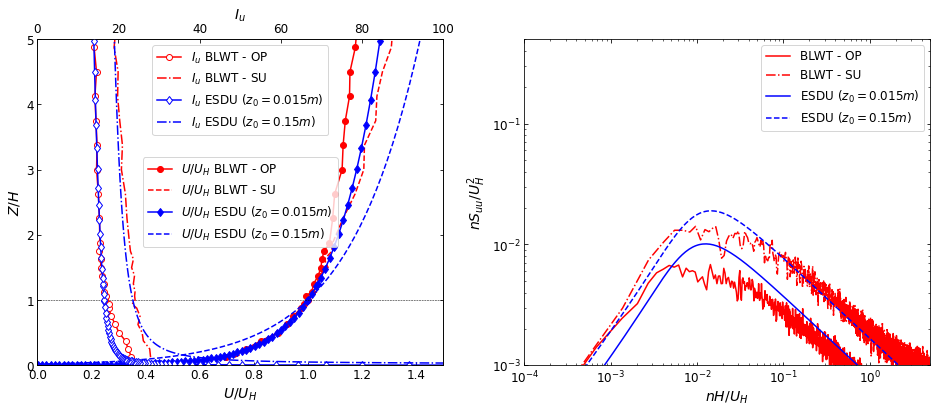

In [39]:
fig = vel.plot__(fig=plt.figure(figsize=[16,6]),zLim=[0,5], IuLim=[0,100], Ulim=[0,1.5],
        col=['r','r','b','b','g','g'],
        marker_Iu=   ['o','None','d','None','v','None'],
        linestyle_Iu=['-','-.',  '-','-.',  '-','--'],
        marker_U=    ['o','None','d','None','v','None'],
        linestyle_U= ['-','--',  '-','--',  '-','--'],
        marker_Spect=   ['None','None','None','None','None','None'],
        linestyle_Spect=['-','-.',  '-','--',  '-','--'],
        alpha_Spect=[0.5, 1.0, 0.5, 1.0],
        IuLgndLoc='upper center', UlgndLoc='center',
        fontSz_axLbl=14, fontSz_axNum=12, fontSz_lgnd=12,
        freqLim=[1e-4, 5], rSuuLim=[1e-3,0.5]
        )
# if saveFigs:
#     fig.savefig(figDir+"windField.svg",format='svg',dpi=1200, bbox_inches='tight')

#### <a id='toc5_1_2_3_'></a>[WT vs. Field vs. ESDU](#toc0_)

Message from Profiles.plotProfile_basic2(): Future feature notice: a table of normalizers like H, Uref, etc. next to the legend.
          Location: D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py
          Function: plotProfile_basic2
          Line number: 5128


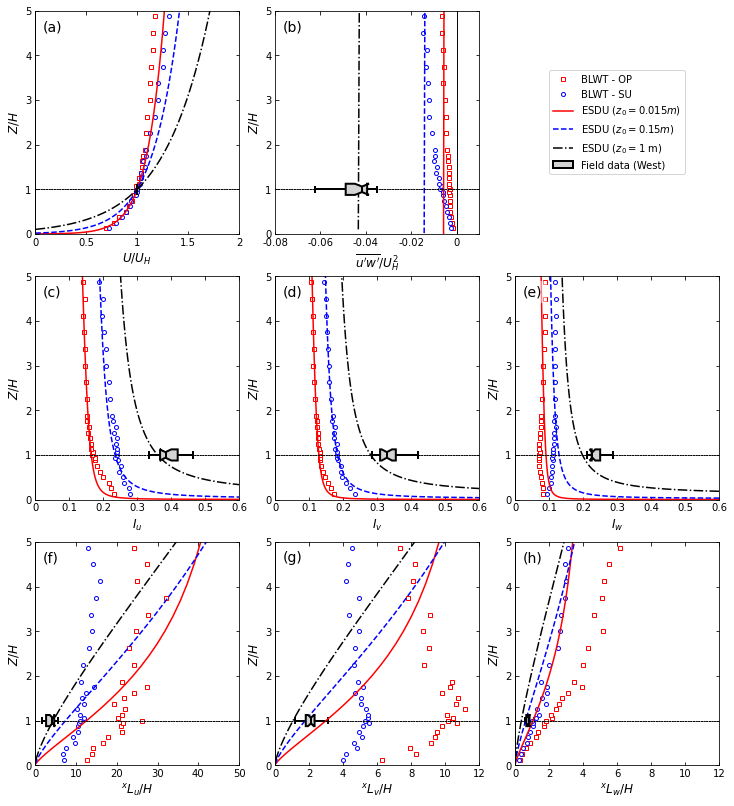

In [122]:
profs = wind.Profiles([vel_OP, vel_SU, vel_E2_ESDU, vel_E3_ESDU, es85_Fld_mnl_obj])# es85_Fld_W_obj, ])
# profs = wind.Profiles([vel_OP, vel_SU, vel_E2_ESDU, vel_E3_ESDU, es85_Fld_NNW_obj, ])

fig, axs = profs.plotProfile_basic2(figsize=[10,11],
            yLimits=[0,5],
            xLimits_U=[0, 2], xLimits_uw=[-0.08, 0.01], 
            xLimits_Iu=[0,0.6], xLimits_Iv=[0,0.6], xLimits_Iw=[0,0.6], 
            xLimits_xLu=[0, 50], xLimits_xLv=[0,12], xLimits_xLw=[0,12], 
            kwargs_plt=[{'color': 'r', 'linewidth':0.5, 'linestyle': 'None',    'marker': 's', 'markersize':4, 'markerfacecolor':'w'},
                        {'color': 'b', 'linewidth':0.5, 'linestyle': 'None',    'marker': 'o', 'markersize':4, 'markerfacecolor':'w'},
                        {'color': 'r', 'linewidth':1.5, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        {'color': 'b', 'linewidth':1.5, 'linestyle': '--',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        {'color': 'k', 'linewidth':1.5, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        ],
            overlayThese=fieldData_West, overlayType='errorBars', 
            kwargs_overlay = {'widths': 0.25,
                            'notch': True,
                            'vert': False,
                            'showfliers': False,
                            'patch_artist': True,
                            'meanline': True,
                            'boxprops': dict(facecolor='lightgray', color='k', linewidth=2, edgecolor='r'),
                            'medianprops': dict(color='k', linewidth=2),
                            'whiskerprops': dict(color='k', linewidth=2),
                            'capprops': dict(color='k', linewidth=2),
                            },
            lgnd_kwargs={'bbox_to_anchor': (0.5, 0.5), 'loc': 'center', 'ncol': 1},
            kwargs_ax={'gridMajor':False}
            )
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
# if saveFigs:
#     fig.savefig(figDir+"profile_West.svg",format='svg',dpi=1200, bbox_inches='tight')
#     print(f"Figure saved to {figDir}profile_basic2.svg")    

In [124]:
# print(fieldData_West.keys())
print(f"West: No. of segments = {len(fieldData_West['Iu'])}")
print(f"\tU_ref = {np.mean(fieldData_West['U_orig']):.2f} +/- {np.std(fieldData_West['U_orig']):.2f}")
print(f"\tIu = {np.mean(fieldData_West['Iu'])*100:.2f} +/- {np.std(fieldData_West['Iu'])*100:.2f}")

# print(fieldData_NNW.keys())
print(f"NNW: No. of segments = {len(fieldData_NNW['Iu'])}")
print(f"\tU_ref = {np.mean(fieldData_NNW['U_orig']):.2f} +/- {np.std(fieldData_NNW['U_orig']):.2f}")
print(f"\tIu = {np.mean(fieldData_NNW['Iu'])*100:.2f} +/- {np.std(fieldData_NNW['Iu'])*100:.2f}")

West: No. of segments = 23
	U_ref = 4.98 +/- 0.67
	Iu = 39.32 +/- 3.13
NNW: No. of segments = 7
	U_ref = 8.29 +/- 0.37
	Iu = 32.86 +/- 1.52


Figure saved: D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/gable27deg/__plots//spectra.svg


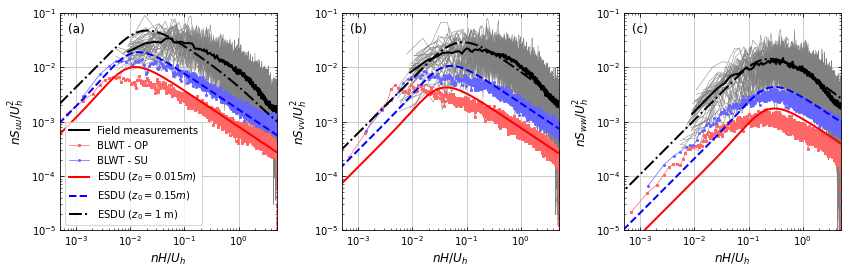

In [125]:
clb = 0.4
r = [1.0, clb, clb, 1.0]
b = [clb, clb, 1.0, 1.0]
kwargs_plt=[{'color': r, 'markerfacecolor':r, 'markeredgecolor':r, 'alpha':1, 'linewidth':0.7, 'linestyle': '-',    'marker': 's', 'markersize':2},
            {'color': b, 'markerfacecolor':b, 'markeredgecolor':b, 'alpha':1, 'linewidth':0.7, 'linestyle': '-',    'marker': 'o', 'markersize':2},
            {'color': 'r', 'linewidth':2, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
            {'color': 'b', 'linewidth':2, 'linestyle': '--',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
            {'color': 'k', 'linewidth':2, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
            ]

fig, _ = profs.plotSpectra(figsize=[14,4], xLimits=[5e-4, 5e0], yLimits=[[1e-5,1e-1],[1e-5,1e-1],[1e-5,1e-1]],
                      xLabel=r'$nH/U_h$', yLabel_Suu=r'$nS_{uu}/U_h^2$', yLabel_Svv=r'$nS_{vv}/U_h^2$', yLabel_Sww=r'$nS_{ww}/U_h^2$',
                      overlayThese=fieldData, overlayType='all_and_avg', lgnd_kwargs={'loc': 'lower left', 'ncol': 1},
                      kwargs_overlay = {'color': 'k', 
                                        'linewidth':2, 
                                        'linestyle': '-',
                                },
                      kwargs_overlay_all = {'color': 'gray',
                                        'linewidth':0.5,
                                        'linestyle': '-',
                                },
                        kwargs_plt=kwargs_plt,)
# if saveFigs:
#         fig.savefig(figDir+'spectra_West.svg', format='svg',dpi=600, bbox_inches='tight')
#                 # fig.savefig(figDir+'spectra.png', format='png',dpi=600, bbox_inches='tight')
#         print(f"Figure saved: {figDir}/spectra.svg")

0.0017908081433317443
0.030208726318252707


### <a id='toc5_1_3_'></a>[Pressure](#toc0_)
#### <a id='toc5_1_3_1_'></a>[$C_p$ contours](#toc0_)

(-352.0, 352.0, -165.0, 165.0)

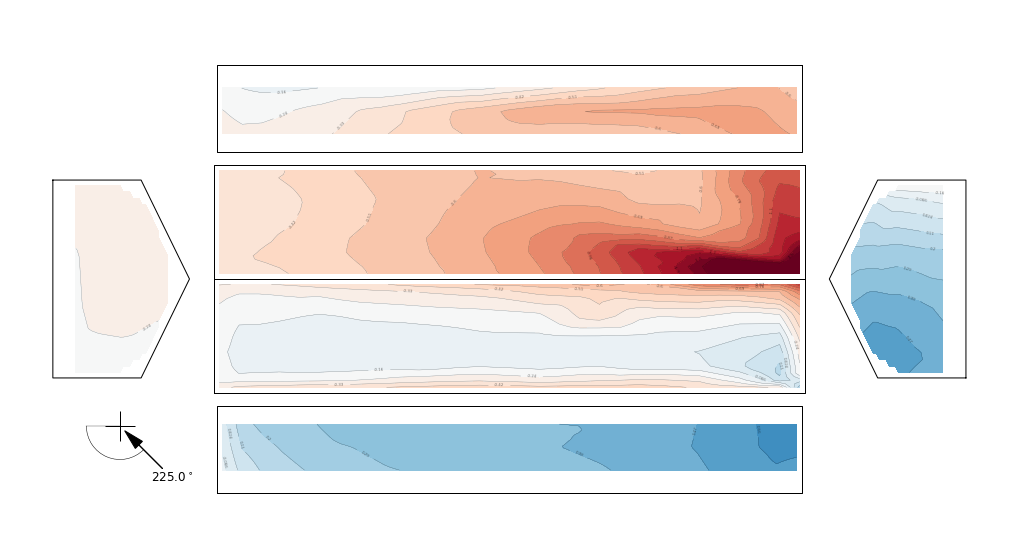

In [45]:
fig = plt.figure(figsize=[18,10])
ax = fig.subplots(1,1)
idx = 25
_ = cp_iso_OP.plotEdges(ax=ax, showName=False)
_ = cp_iso_SU.plotTapCpStatContour(fieldName='mean', dxnIdx=idx, ax=ax, fldRange=[-1.5, 1.1],nLvl=30)
_ = cp_iso_OP.plotAoA_definition(ax=ax, AoAs=[cp_iso_OP.AoA[idx],])

ax.axis('equal')
ax.axis('off')

# fig = plt.figure(figsize=[18,10])
# ax = fig.subplots(1,1)
# idx = 20
# _ = cp_iso_OP.plotEdges(ax=ax, showName=False)
# _ = cp_iso_SU.plotTapCpStatContour(fieldName='mean', dxnIdx=idx, ax=ax, fldRange=[-1.5, 1.1],nLvl=30)
# _ = cp_iso_OP.plotAoA_definition(ax=ax, AoAs=[cp_iso_OP.AoA[idx],])

# ax.axis('equal')
# ax.axis('off')

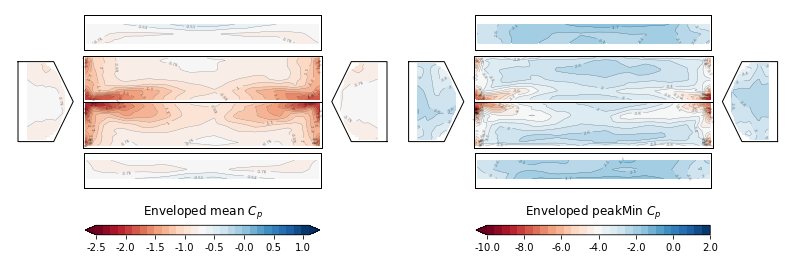

In [46]:
from matplotlib.ticker import FuncFormatter

# fig, axs = plt.subplots(5,2,figsize=[12,14])
fig, axs = plt.subplots(2,2,figsize=[14,7])
ax_cbar1 = axs[1,0]
ax_cbar2 = axs[1,1]
# fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
# completely remove the gap between the plots
fig.subplots_adjust(hspace=0, wspace=0)

# for i, cp in enumerate([cp_iso_OP, cp_iso_SU, cp_sur_OP, cp_sur_SU]):
for i, cp in enumerate([cp_iso_OP, ]):

    # fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)
    fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)
    
    ax = axs[i,0]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$")
    cp.plotEdges(ax=ax, showName=False)
    ax.axis('equal')
    ax.axis('off')
    if i == 0:
        ax_cbar1.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar1, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=12, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar1.get_position()
        # new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.7, pos.width*0.8, pos.height*0.12]
        new_pos = [pos.x0+pos.width*0.2, pos.y0+pos.height*0.8, pos.width*0.6, pos.height*0.05]
        ax_cbar1.set_position(new_pos)

    fld, fldrange, ticks = 'peakMin', [-10., 2.], np.linspace(-10,2.0, 7)

    ax = axs[i,1]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$", extend='min')
    cp.plotEdges(ax=ax, showName=False)
    ax.axis('equal')
    ax.axis('off')
    if i == 0:
        ax_cbar2.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar2, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=12, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar2.get_position()
        # new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.7, pos.width*0.8, pos.height*0.12]
        new_pos = [pos.x0+pos.width*0.2, pos.y0+pos.height*0.8, pos.width*0.6, pos.height*0.05]
        ax_cbar2.set_position(new_pos)
# if saveFigs:
#     fileName = figDir+f"CpContour_OP_mean_peak.svg"
#     fig.savefig(fileName,format='svg',dpi=1200, bbox_inches='tight')
#     print(f"Figure saved to {fileName}")
    

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:1263: UserWarning: No contour levels were found within the data range.
  cObj_l = ax.contour(X, Y, Z, levels=levels, **kwargs_contourEdge)


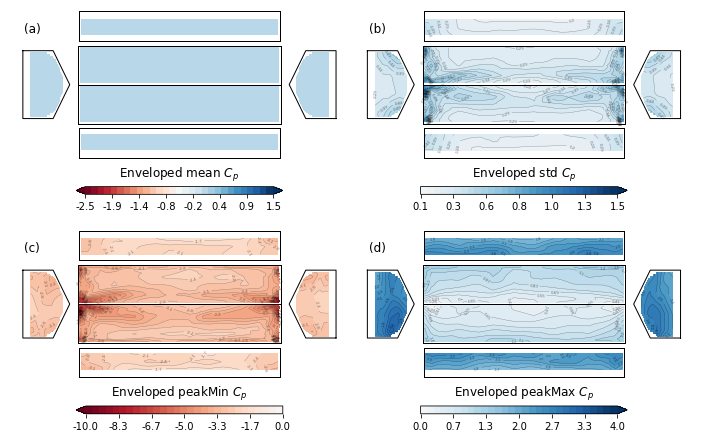

In [47]:
from matplotlib.ticker import FuncFormatter

# fig, axs = plt.subplots(5,2,figsize=[12,14])
fig, axs = plt.subplots(4,2,figsize=[10,9])
ax_cbar1 = axs[1,0]
ax_cbar2 = axs[1,1]
ax_cbar3 = axs[3,0]
ax_cbar4 = axs[3,1]
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
# completely remove the gap between the plots
fig.subplots_adjust(hspace=0, wspace=0)

cp = cp_iso_OP

axSwitch = 'off'

# fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)
fld, fldrange, ticks = 'mean', [-2.5, 1.5], np.linspace(-2.5,1.5,8)
ax = axs[0,0]
im = cp.plotTapCpStatContour(ax=ax, envelopeType='categorical',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$")
cp.plotEdges(ax=ax, showName=False)
ax.text(0.05, 0.9, '(a)', transform=ax.transAxes, fontsize=12, va='top', ha='left')
ax.axis('equal')
ax.axis(axSwitch)
ax_cbar1.axis('on')
cbar = fig.colorbar(im[0], cax=ax_cbar1, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=12, rotation=0, labelpad=10)
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.xaxis.set_label_position('top')
pos = ax_cbar1.get_position()
# new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.7, pos.width*0.8, pos.height*0.12]
new_pos = [pos.x0+pos.width*0.2, pos.y0+pos.height*0.8, pos.width*0.6, pos.height*0.05]
ax_cbar1.set_position(new_pos)


fld, fldrange, ticks = 'std', [0.1, 1.5], np.linspace(0.1,1.5, 7)
ax = axs[0,1]
im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$", extend='max',
                                 cmap=wind.sub_cmap(cmap='RdBu', start=0.5, stop=1.0, n=30))
cp.plotEdges(ax=ax, showName=False)
ax.text(0.05, 0.9, '(b)', transform=ax.transAxes, fontsize=12, va='top', ha='left')
ax.axis('equal')
ax.axis(axSwitch)
ax_cbar2.axis('on')
cbar = fig.colorbar(im[0], cax=ax_cbar2, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=12, rotation=0, labelpad=10)
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.xaxis.set_label_position('top')
pos = ax_cbar2.get_position()
# new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.7, pos.width*0.8, pos.height*0.12]
new_pos = [pos.x0+pos.width*0.2, pos.y0+pos.height*0.8, pos.width*0.6, pos.height*0.05]
ax_cbar2.set_position(new_pos)


fld, fldrange, ticks = 'peakMin', [-10., 0.], np.linspace(-10,0.0, 7)
ax = axs[2,0]
im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$", extend='min',
                                 cmap=wind.sub_cmap(cmap='RdBu', stop=0.5, n=30))
cp.plotEdges(ax=ax, showName=False)
ax.text(0.05, 0.9, '(c)', transform=ax.transAxes, fontsize=12, va='top', ha='left')
ax.axis('equal')
pos1 = ax.get_position()
new_pos = [pos1.x0, pos1.y0+pos1.height*0.6, pos1.width, pos1.height]
ax.axis(axSwitch)
ax.set_position(new_pos)
ax_cbar3.axis('on')
cbar = fig.colorbar(im[0], cax=ax_cbar3, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=12, rotation=0, labelpad=10)
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.xaxis.set_label_position('top')
pos = ax_cbar3.get_position()
# new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.7, pos.width*0.8, pos.height*0.12]
new_pos = [pos.x0+pos.width*0.2, pos.y0+pos.height*0.8+pos1.height*0.6, pos.width*0.6, pos.height*0.05]
ax_cbar3.set_position(new_pos)


fld, fldrange, ticks = 'peakMax', [0., 4.], np.linspace(0, 4.0, 7)
ax = axs[2,1]
im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$", extend='max',
                             cmap=wind.sub_cmap(cmap='RdBu', start=0.5, stop=1.0, n=30))
cp.plotEdges(ax=ax, showName=False)
ax.text(0.05, 0.9, '(d)', transform=ax.transAxes, fontsize=12, va='top', ha='left')
ax.axis('equal')
pos1 = ax.get_position()
new_pos = [pos1.x0, pos1.y0+pos1.height*0.6, pos1.width, pos1.height]
ax.axis(axSwitch)
ax.set_position(new_pos)
ax_cbar4.axis('on')
cbar = fig.colorbar(im[0], cax=ax_cbar4, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=12, rotation=0, labelpad=10)
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.xaxis.set_label_position('top')
pos = ax_cbar4.get_position()
# new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.7, pos.width*0.8, pos.height*0.12]
new_pos = [pos.x0+pos.width*0.2, pos.y0+pos.height*0.8+pos1.height*0.6, pos.width*0.6, pos.height*0.05]
ax_cbar4.set_position(new_pos)


# # if saveFigs:
# fileName = figDir+f"CpContour_OP_mean_std_peak.svg"
# fig.savefig(fileName,format='svg',dpi=1200, bbox_inches='tight')
# print(f"Figure saved to {fileName}")
    

#### <a id='toc5_1_3_2_'></a>[$C_p$ vs. AoA per tap](#toc0_)

In [126]:
# cps = wind.BldgCps([cp_iso_OP, cp_iso_SU, cp_sur_OP, cp_sur_SU])
cps = wind.BldgCps([cp_sur_SU, ] )
# cps = wind.BldgCps([cp_iso_OP, cp_sur_OP])
# cps = wind.BldgCps([cp_iso_SU, cp_sur_SU])
# cps = wind.BldgCps([cp_sur_OP, cp_sur_SU])

factors_WT = []
for cp in cps.memberBldgs:
    print(cp.name)
    factors_WT.append(cp.CandCLoad_factor(debugMode=True, format='NBCC'))

Number of member bldgs: 1
BLWT-SU-sur
Computing C&C Load factor for BLWT-SU-sur ...
full_scale_duration = 3599.9999999999995
z0 = 0.00146m (@MS), 0.146m (@FS)

Calculating the lumped reference velocity conversion factors for C&C wind loads.
		From 		---> 	 To	===>	Factor
Type		simulated 	---> 	 NBCC
z0		0.146 		---> 	 0.03	===>	0.755
Z		8 		---> 	 10	===>	0.897
gust_dur	3600 		---> 	 3600	===>	1
			COMBINED FACTOR			0.6776

C&C factor for case BLWT-SU-sur = 0.6776393717768808


In [49]:
# # for the Ottawa site
# z0,es_OT = wind.fitESDUgivenIuRef(10, 0.2174)
# print(z0)

# import copy
# correctionFactor = windCodes.CpConversionFactor(from_='simulated', to_='NBCC', from_gustDuration=15*60, debugMode=True, from_Z=H_FS, from_z0=z0, )
# # deep copy the data
# fs_CpData_corrected = copy.deepcopy(fs_CpData)
# for key in fs_CpData_corrected.keys():
#     if key == 'AoA':
#         continue
#     fs_CpData_corrected[key] *= correctionFactor

In [127]:

import copy
correctionFactor = windCodes.CpConversionFactor(from_='simulated', to_='NBCC', from_gustDuration=15*60, debugMode=True, from_Z=H_FS, from_z0=es85_Fld_mnl_obj.z0_Iu, )
# deep copy the data
fs_CpData_corrected = copy.deepcopy(fs_CpData)
for key in fs_CpData_corrected.keys():
    if key == 'AoA':
        continue
    fs_CpData_corrected[key] *= correctionFactor



Calculating the lumped reference velocity conversion factors for C&C wind loads.
		From 		---> 	 To	===>	Factor
Type		simulated 	---> 	 NBCC
z0		1 		---> 	 0.03	===>	0.384
Z		9.81 		---> 	 10	===>	0.983
gust_dur	900 		---> 	 3600	===>	1.09
			COMBINED FACTOR			0.4132



In [128]:
print(cp_iso_OP.Uref_FS)

None


Number of member bldgs: 4
TO DO: avoid displaying 'nan'. Instead display '-'


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:1843: UserWarning: z0_Iu and z0_U are not close. Using z0_U to calculate shear velocity.
  warnings.warn("z0_Iu and z0_U are not close. Using z0_U to calculate shear velocity.")


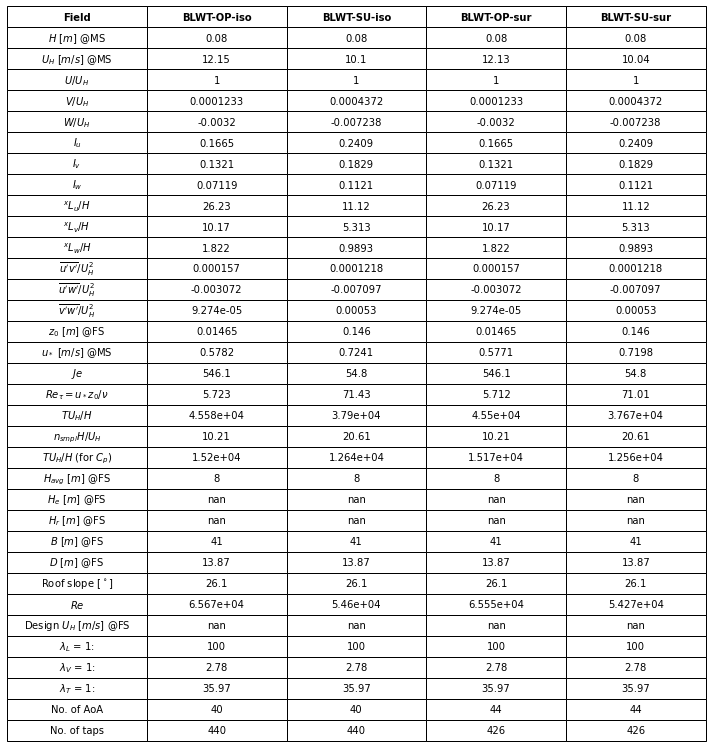

Figure saved to D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/gable27deg/__plots/wt_all_paramsTable.svg


In [129]:
wt_all = wind.BldgCps([cp_iso_OP, cp_iso_SU, cp_sur_OP, cp_sur_SU,])
fig, _ = wt_all.plotParamsTable()
if saveFigs:
    fig.savefig(figDir+"wt_all_paramsTable.svg",format='svg',dpi=1200, bbox_inches='tight')
    print(f"Figure saved to {figDir}wt_all_paramsTable.svg")

In [51]:
idx = cp_sur_SU.tapIdxOf(fullScaleTaps)
aoa = cp_sur_SU.AoA
cpPeak = cp_sur_SU.CpStats['peakMin'][:,idx]*factors_WT[0]
print(np.shape(cpPeak))

print(fs_CpData.keys())
fld_aoa = fs_CpData['AoA']
fld_cp = fs_CpData['peakMin']*correctionFactor

# sort the data by AoA
idx = np.argsort(fld_aoa)
fld_aoa = fld_aoa[idx]
fld_cp = fld_cp[idx,:]

# interpolate the simulated data to the same AoA as the field data
cpPeak_interp = np.zeros(np.shape(fld_cp))
for i in range(np.shape(fld_cp)[1]):
    cpPeak_interp[:,i] = np.interp(fld_aoa, aoa, cpPeak[:,i])

# get difference between the field and simulated data
cpPeak_diff = cpPeak_interp - fld_cp
cpPeak_diff_mean = np.mean(cpPeak_diff, axis=0)

cpPeak_ratio = fld_cp / cpPeak_interp
cpPeak_ratio_mean = np.mean(cpPeak_ratio, axis=0)

print(np.shape(cpPeak_diff))
print(np.shape(cpPeak_diff_mean))
print(cpPeak_diff_mean)
print(np.mean(cpPeak_diff_mean))

print(np.shape(cpPeak_ratio))
print(np.shape(cpPeak_ratio_mean))
print(cpPeak_ratio_mean)
print(np.mean(cpPeak_ratio_mean))

# # plot the difference
# fig = plt.figure(figsize=[12,6])
# ax = fig.subplots(1,1)
# ax.plot(fullScaleTaps, cpPeak_diff_mean, 'k-', label='Mean')
# ax.plot(fullScaleTaps, cpPeak_diff.T, 'k.', label='All')
# ax.set_xlabel('Tap index')
# ax.set_ylabel(r'$C_p$ difference')
# ax.set_title('Difference between simulated and field data')
# ax.legend()
# ax.grid(True)
print(6*2.8)

(44, 14)
dict_keys(['AoA', 'mean', 'std', 'peakMin', 'peakMax'])
(44, 14)
(14,)
[1.30733453 2.77199865 2.52879359 2.04414056 2.35046421 2.7824852
 2.57292344 2.37873873 1.79793929 2.69955232 2.13553588 1.36985554
 1.4836926  1.05049814]
2.0909966195796694
(44, 14)
(14,)
[1.82231641 2.65922218 2.840252   2.50349561 3.43643027 3.55871573
 3.2369349  3.43937936 3.05908519 2.67623286 2.29161783 2.47590346
 3.57690712 2.37215216]
2.8534746478910202
16.799999999999997


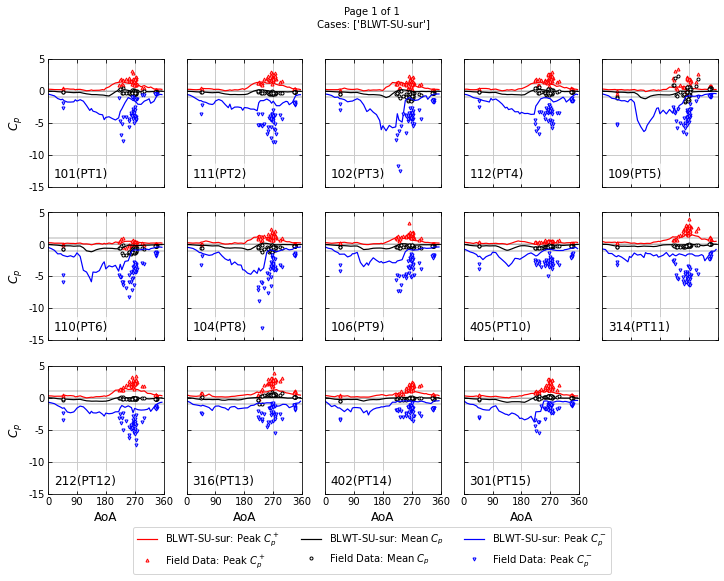

In [135]:
cols = ['r','k','b','g','m','r','k','b','g','m']
# mrkrs = ['^','o','v','s','p','d','.','*','<','>','h']
mrkrs = ['','','','','','','','','','','']
ls=['-','-','-','-','-','-','-','-','-','-',]
kwargs_perFld = [[{ 'color':cols[i], 
                    'marker':mrkrs[i], 
                    'ls':ls[i],
                    'markersize':2,
                    'linewidth':1.2,
                    } for i in range(3)]
                    for c in range(cps.N_bldgs)] 

# figs, all_axes = cps.plotTapCpStatsPerAoA(
#                 # fields=['mean','std'], fldRange=[-2.5,1.5],
#                 fields=['peakMax','mean','peakMin'], fldRange=[-20,10],
#                 xticks=np.linspace(0,360,5),
#                 tapsToPlot=fullScaleTaps, pageNo_xy=(0.5,0.06),nCols=5, nRows=3, figsize=[12,8], 
#                 mrkrSize=2,
#                 kwargs_perFld=kwargs_perFld, nLgndCols=3,
#                 overlayThis=fs_CpData, overlay_AoA=fs_CpData['AoA'], overlayLabel='Field Data',
#                 kwargs_overlay=[{'color':'r','marker':'^','ls':'','markersize':3,'linewidth':0.5, 'markerfacecolor':'w'},
#                                 {'color':'k','marker':'o','ls':'','markersize':3,'linewidth':0.5, 'markerfacecolor':'w'},
#                                 {'color':'b','marker':'v','ls':'','markersize':3,'linewidth':0.5, 'markerfacecolor':'w'},
#                                 ],
#                 legend_bbox_to_anchor=(0.5, 0.97),
#                 simpleLabel=False,
#                 )

from matplotlib.backends.backend_pdf import PdfPages
# if saveFigs:
#     pp = PdfPages(figDir+'nrcNB_CpStatsPerAoA.pdf')
#     for p,fig in enumerate(figs):
#         fig.savefig(pp, format='pdf', dpi=300, bbox_inches='tight')
#         fig.savefig(figDir+f"nrcNB_CpStatsPerAoA_pg_{p+1}.svg",format='svg',dpi=1200, bbox_inches='tight')
#     pp.close()

figs, all_axes = cps.plotTapCpStatsPerAoA(
                # fields=['mean','std'], fldRange=[-2.5,1.5],
                fields=['peakMax','mean','peakMin'], fldRange=[-15,5],
                xticks=np.linspace(0,360,5), scaleFactors=factors_WT,
                tapsToPlot=fullScaleTaps, pageNo_xy=(0.5,0.97),nCols=5, nRows=3, figsize=[12,8], 
                mrkrSize=2,
                kwargs_perFld=kwargs_perFld, nLgndCols=3,
                overlayThis=fs_CpData_corrected, overlay_AoA=fs_CpData['AoA'], overlayLabel='Field Data',
                kwargs_overlay=[{'color':'r','marker':'^','ls':'','markersize':3,'linewidth':0.5, 'markerfacecolor':'w'},
                                {'color':'k','marker':'o','ls':'','markersize':3,'linewidth':0.5, 'markerfacecolor':'w'},
                                {'color':'b','marker':'v','ls':'','markersize':3,'linewidth':0.5, 'markerfacecolor':'w'},
                                ],
                legend_bbox_to_anchor=(0.5, 0.075),
                simpleLabel=False,
                )
# if saveFigs:
#     pp = PdfPages(figDir+'nrcNB_CpStatsPerAoA_corrected.pdf')
#     for p,fig in enumerate(figs):
#         fig.savefig(pp, format='pdf', dpi=300, bbox_inches='tight')
#         fig.savefig(figDir+f"nrcNB_CpStatsPerAoA_pg_{p+1}_corrected.svg",format='svg',dpi=1200, bbox_inches='tight')
#         pp.close()

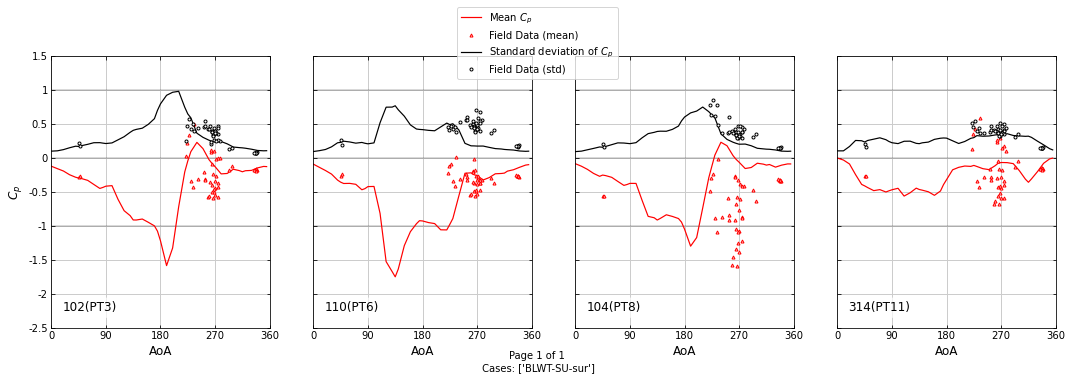

In [53]:
taps=[102, 110, 104, 314]

figs, all_axes = cps.plotTapCpStatsPerAoA(
                fields=['mean','std'], fldRange=[-2.5,1.5],
                # fields=['peakMax','mean','peakMin'], fldRange=[-10,5],
                xticks=np.linspace(0,360,5),
                #fullScaleTaps, pageNo_xy=(0.5,0.06),nCols=5, nRows=3, figsize=[18,15], 
                tapsToPlot=taps, pageNo_xy=(0.5,0.06),nCols=4, nRows=1, figsize=[18,5],
                mrkrSize=2,
                kwargs_perFld=kwargs_perFld,
                overlayThis=fs_CpData_corrected, overlay_AoA=fs_CpData['AoA'], overlayLabel='Field Data',
                kwargs_overlay=[{'color':'r','marker':'^','ls':'','markersize':3,'linewidth':0.5, 'markerfacecolor':'w'},
                                {'color':'k','marker':'o','ls':'','markersize':3,'linewidth':0.5, 'markerfacecolor':'w'},
                                {'color':'b','marker':'v','ls':'','markersize':3,'linewidth':0.5, 'markerfacecolor':'w'},
                                ],
                legend_bbox_to_anchor=(0.5, 1.03),
                simpleLabel=True,
                )

# if saveFigs:
#     for p,fig in enumerate(figs):
#         fig.savefig(figDir+f"nrcNB{caseID}{exp}_CpStatsPerAoA_pg_{p+1}.svg",format='svg',dpi=1200, bbox_inches='tight')


#### <a id='toc5_1_3_3_'></a>[C&C pressure coefficients from codes](#toc0_)

In [54]:
print(windCodes.getDurstFactor(3)**1)

1.5204376989536799


In [55]:
print(fs_CpData.keys())
print(fs_CpData['peakMin'].shape)

dict_keys(['AoA', 'mean', 'std', 'peakMin', 'peakMax'])
(44, 14)


In [107]:
nomArea = 0.16
nSegs = fs_CpData['peakMin'].shape[0]

#             [1, 3, 5, 6, 2, 4]
taps_Zone_c = [101, 102, 109, 110, 111, 112]
idx_c = [i for i, x in enumerate(fullScaleTaps) if x in taps_Zone_c]

#             [8, 9, 10]
taps_Zone_s = [104, 106, 405]
idx_s = [i for i, x in enumerate(fullScaleTaps) if x in taps_Zone_s]

#             [12, 15, 11, 13, 14]
taps_Zone_r = [212, 301, 314, 316, 402]
# taps_Zone_r = [314, 212, 316, 402, 301]
idx_r = [i for i, x in enumerate(fullScaleTaps) if x in taps_Zone_r]

print([fullScaleTaps[i] for i in idx_c])

fieldCandC = {}
fieldCandC['Name'] = 'Field data'
fieldCandC['Min'] = {}
fieldCandC['Min']['area'] = {}
fieldCandC['Min']['area']["NBCC 2020, Zone c"] = [nomArea for _ in idx_c]
fieldCandC['Min']['area']["NBCC 2020, Zone s"] = [nomArea for _ in idx_s]
fieldCandC['Min']['area']["NBCC 2020, Zone r"] = [nomArea for _ in idx_r]
fieldCandC['Min']['area']["NBCC 2020, Zone e"] = []
fieldCandC['Min']['area']["NBCC 2020, Zone w"] = []
fieldCandC['Min']['value'] = {}
fieldCandC['Min']['value']["NBCC 2020, Zone c"] = [fs_CpData['peakMin'][:,i] for i in idx_c]
fieldCandC['Min']['value']["NBCC 2020, Zone s"] = [fs_CpData['peakMin'][:,i] for i in idx_s]
fieldCandC['Min']['value']["NBCC 2020, Zone r"] = [fs_CpData['peakMin'][:,i] for i in idx_r]
fieldCandC['Min']['value']["NBCC 2020, Zone e"] = []
fieldCandC['Min']['value']["NBCC 2020, Zone w"] = []

fieldCandC['Max'] = {}
fieldCandC['Max']['area'] = {}
fieldCandC['Max']['area']["NBCC 2020, Zone c"] = [nomArea for _ in idx_c]
fieldCandC['Max']['area']["NBCC 2020, Zone s"] = [nomArea for _ in idx_s]
fieldCandC['Max']['area']["NBCC 2020, Zone r"] = [nomArea for _ in idx_r]
fieldCandC['Max']['area']["NBCC 2020, Zone e"] = []
fieldCandC['Max']['area']["NBCC 2020, Zone w"] = []
fieldCandC['Max']['value'] = {}
fieldCandC['Max']['value']["NBCC 2020, Zone c"] = [fs_CpData['peakMax'][:,i] for i in idx_c]
fieldCandC['Max']['value']["NBCC 2020, Zone s"] = [fs_CpData['peakMax'][:,i] for i in idx_s]
fieldCandC['Max']['value']["NBCC 2020, Zone r"] = [fs_CpData['peakMax'][:,i] for i in idx_r]
fieldCandC['Max']['value']["NBCC 2020, Zone e"] = []
fieldCandC['Max']['value']["NBCC 2020, Zone w"] = []

print(np.shape(fieldCandC['Max']['area']["NBCC 2020, Zone c"]))
print(np.max(fieldCandC['Max']['value']["NBCC 2020, Zone c"]))

# x = windCodes.NBCC2020_CpCg(Figure='4.1.7.6.-E', subfig='a')
# print(json.dumps(x, indent=4))

[101, 111, 102, 112, 109, 110]
(6,)
8.206577


Computing C&C Load factor for BLWT-OP-iso ...
full_scale_duration = 3600.0
z0 = 0.000146m (@MS), 0.0146m (@FS)

Calculating the lumped reference velocity conversion factors for C&C wind loads.
		From 		---> 	 To	===>	Factor
Type		simulated 	---> 	 NBCC
z0		0.0146 		---> 	 0.03	===>	1.09
Z		8 		---> 	 10	===>	0.933
gust_dur	3600 		---> 	 3600	===>	1
			COMBINED FACTOR			1.021

C&C factor for case BLWT-OP-iso = 1.0210600459502244
Computing C&C Load factor for BLWT-SU-iso ...
full_scale_duration = 3600.0
z0 = 0.00146m (@MS), 0.146m (@FS)

Calculating the lumped reference velocity conversion factors for C&C wind loads.
		From 		---> 	 To	===>	Factor
Type		simulated 	---> 	 NBCC
z0		0.146 		---> 	 0.03	===>	0.755
Z		8 		---> 	 10	===>	0.897
gust_dur	3600 		---> 	 3600	===>	1
			COMBINED FACTOR			0.6776

C&C factor for case BLWT-SU-iso = 0.6776393717768808


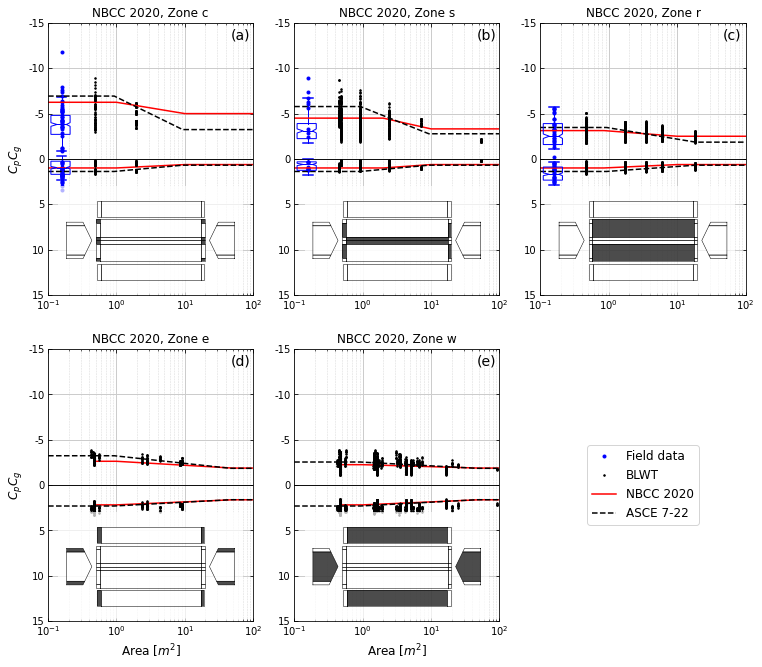

Saved figure: D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/gable27deg/__plots/CandC_Fig_E_iso.svg


In [138]:
fig = plt.figure(figsize=[12.5,11])
plt.tight_layout()

NumZones = bldg_iso.NumZones
nCols = min(3, NumZones)
nRows = int(np.ceil(NumZones/nCols))
axs = fig.subplots(nRows, nCols, sharex=False, sharey=False)

for I, zKey in enumerate(bldg_iso.zoneDictKeys):
    i, j = np.unravel_index(I, axs.shape)
    ax = axs[i,j]
    ax.set_title(zKey)
    if i == axs.shape[0]-1:
        ax.set_xlabel(r'Area [$m^2$]')
    if j == 0:
        ax.set_ylabel(r"$C_pC_g$")
    ax.set_xlim([0.1,100])
    ax.set_ylim([-15,15])

    wind.formatAxis(ax, gridMinor=True)

NBCC_dxnFactor = 0.8
for i, cp in enumerate([cp_iso_OP, cp_iso_SU]):
    if i == 0:
        _, _, area, peakMin, peakMax = cp.plotCandC_load(fig=fig, axs=axs, 
                                figSize=[12.5,12], sharex=False, sharey=False,
                                plotExtremesPerNominalArea=False, areaFactor=areaFactor_toFSm2, invertYAxis=True,
                                # xLimits=[0.1,100], yLimits=[-23,5],
                                debugMode=True,
                                CandCLoadFormat='NBCC',
                                yLabel=r"$C_pC_g$",
                                label_min=r"BLWT", label_max=None,
                                kwargs_min={'color':'k', 'marker':'.', 'markersize':3,}, # 'linestyle':'-'},
                                kwargs_max={'color':'k', 'marker':'.', 'markersize':3,}, # 'linestyle':'-'},
                                overlayThese=[
                                    fieldCandC,
                                    windCodes.NBCC2020_CpCg(Figure='4.1.7.6.-E', subfig='a'),
                                    windCodes.ASCE7_22_GCp(Figure='30.3-2C', subfig='a', outAs='NBCC'),
                                    ],
                                overlayFactors=[
                                    correctionFactor,
                                    1.0/NBCC_dxnFactor,
                                    (windCodes.getDurstFactor(3.0))**2,
                                    ],
                                kwargs_overlay=(
                                    {'color':'b', 'linestyle':'None', 'marker':'.', 'markersize':6,'markeredgewidth':1.0},
                                    {'color':'r',}, 
                                    {'color':'k', 'linestyle':'--'},
                                    ),
                                legend_ax_idx=5,
                                kwargs_legend={'loc':'center', 'fontsize':12},
                                subplotLabels=['(a)','(b)','(c)','(d)','(e)',''], subplotLabels_xy=[0.89,0.94],
                                kwargs_ax={'gridMinor':True},
                                insetBounds=[0.05,0.0,0.9,0.4],
                                zoneShadeColor='k',
                                )
    else:
        _ = cp.plotCandC_load(fig=fig, axs=axs, 
                                figSize=[12.5,12], sharex=False, sharey=False,
                                plotExtremesPerNominalArea=False, areaFactor=areaFactor_toFSm2, #invertYAxis=True,
                                # xLimits=[0.1,100], yLimits=[-23,5],
                                debugMode=True,
                                CandCLoadFormat='NBCC',
                                yLabel=r"$C_pC_g$",
                                label_min=None, label_max=None,
                                kwargs_min={'color':'k', 'marker':'.', 'markersize':3,},
                                kwargs_max={'color':'k', 'marker':'.', 'markersize':3,},
                                legend_ax_idx=5,
                                kwargs_legend={'loc':'center', 'fontsize':12},
                                kwargs_ax={'gridMinor':True},
                                insetBounds=[0.05,0.0,0.9,0.4],
                                zoneShadeColor='k',
                                plotZoneGeom=False,
                                )
plt.show()

# if saveFigs:
#     fig.savefig(figDir+"CandC_Fig_E_iso.svg",format='svg',dpi=1200, bbox_inches='tight')
#     print(f"Saved figure: {figDir}CandC_Fig_E_iso.svg")


#### Data export

In [143]:
file = exportDir+'wt_CandC_load_iso_OP.xlsx'
cp_iso_OP.writeCandCloadToXLSX(file, areaFactor=areaFactor_toFSm2, format='NBCC', extremesPerNominalArea=False)
file = exportDir+'wt_CandC_load_iso_SU.xlsx'
cp_iso_SU.writeCandCloadToXLSX(file, areaFactor=areaFactor_toFSm2, format='NBCC', extremesPerNominalArea=False)
file = exportDir+'wt_CandC_load_sur_OP.xlsx'
cp_sur_OP.writeCandCloadToXLSX(file, areaFactor=areaFactor_toFSm2, format='NBCC', extremesPerNominalArea=False)
file = exportDir+'wt_CandC_load_sur_SU.xlsx'
cp_sur_SU.writeCandCloadToXLSX(file, areaFactor=areaFactor_toFSm2, format='NBCC', extremesPerNominalArea=False)

In [145]:
file = exportDir+'wt_CpStats_iso_OP.xlsx'
cp_iso_OP.writeCpStatsToXLSX(file, taps=fullScaleTaps)
file = exportDir+'wt_CpStats_iso_SU.xlsx'
cp_iso_SU.writeCpStatsToXLSX(file, taps=fullScaleTaps)
file = exportDir+'wt_CpStats_sur_OP.xlsx'
cp_sur_OP.writeCpStatsToXLSX(file, taps=fullScaleTaps)
file = exportDir+'wt_CpStats_sur_SU.xlsx'
cp_sur_SU.writeCpStatsToXLSX(file, taps=fullScaleTaps)

Saved Cp stats to D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/gable27deg/__export/wt_CpStats_iso_OP.xlsx
Saved Cp stats to D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/gable27deg/__export/wt_CpStats_iso_SU.xlsx
Saved Cp stats to D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/gable27deg/__export/wt_CpStats_sur_OP.xlsx
Saved Cp stats to D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/gable27deg/__export/wt_CpStats_sur_SU.xlsx


In [139]:
print(figDir)

D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/gable27deg/__plots/
